<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [ ]:
!pip install -r requirements.txt -q

In [ ]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса.

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [ ]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 25.8MB/s]                   


Взглянем на то, что представляют из себя данные:

In [ ]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [ ]:
df['CashOut'] = -df['CashOut']
df['netto'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

Для начала построим графики целых временных рядов. Можем наблюдать немного проявляющуюся сезонность, особенно на графике сегмента `netto`. Отчётливого тренда не наблюдается. На сегменте `CashOut` видны заметные выбросы.

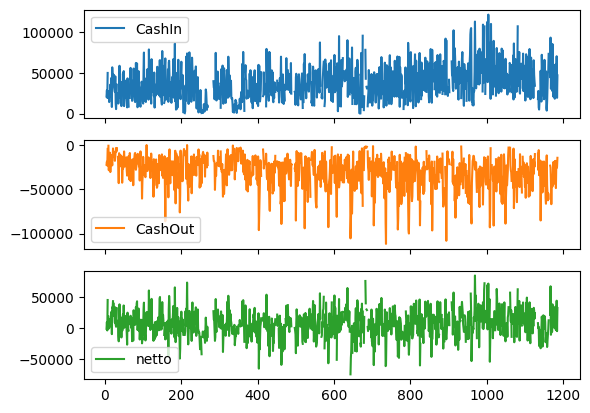

In [ ]:
df.plot(subplots=True)
plt.show()

Посмотрим на отдельный месяц $-$ январь 2019 года. Здесь сезонность проявляется чётко, даже заметны тренды на графиках `CashOut`, `netto`.

Сезонность характерна для любого разреза в месяц / неделю, тренды наблюдаются не везде.

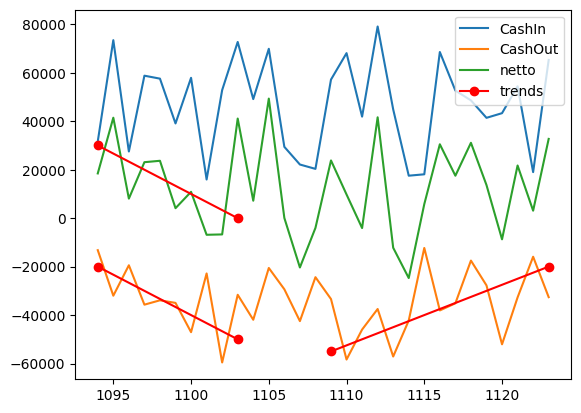

In [ ]:
df[-93:-62].plot()
plt.plot([1094, 1103], [-20000, -50000], 'r', marker='o', label='trends')
plt.plot([1094, 1103], [30000, 0], 'r', marker='o')
plt.plot([1109, 1123], [-55000, -20000], 'r', marker='o')
plt.legend()
plt.show()

`CashIn`, `CashOut` коррелируют с `netto`, что неудивительно.

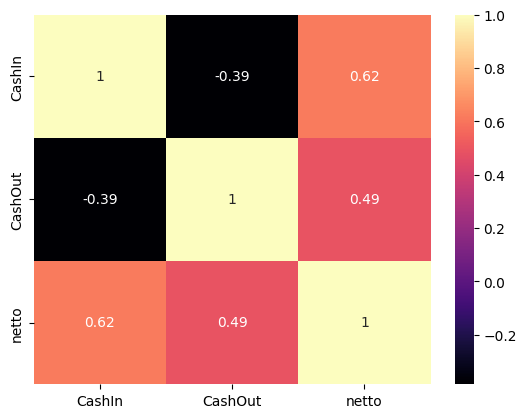

In [ ]:
sns.heatmap(df.corr('pearson'), annot=True, cmap=sns.color_palette('magma', as_cmap=True))
plt.show()

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [ ]:
from etna.datasets import TSDataset

In [ ]:
df_in_etna_format = deepcopy(df)

In [ ]:
df_in_etna_format['timestamp'] = pd.to_datetime(df_in_etna_format['Date'])
df_in_etna_format.drop(columns=['Date'], inplace=True)
df_in_etna_format = pd.melt(df_in_etna_format, id_vars=['timestamp'], value_vars=['CashIn', 'CashOut', 'netto'])
df_in_etna_format.rename(columns={'variable' : 'segment', 'value' : 'target'}, inplace=True)

In [ ]:
df_in_etna_format.head()

timestamp segment   target
0 2016-01-05  CashIn  20840.0
1 2016-01-06  CashIn  28460.0
2 2016-01-07  CashIn  19250.0
3 2016-01-08  CashIn  49770.0
4 2016-01-09  CashIn      NaN

In [ ]:
df_in_etna_format = TSDataset.to_dataset(df_in_etna_format)
ts = TSDataset(df_in_etna_format, freq='D')

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [ ]:
from etna.transforms import DensityOutliersTransform, TimeSeriesImputerTransform
from etna.analysis import plot_imputation, get_anomalies_density, plot_anomalies

Наблюдаем кучу пропущенных значений:

In [ ]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182          101             3   
CashOut       2016-01-05    2019-03-31    1182           88             3   
netto         2016-01-05    2019-03-31    1182          110             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D  
netto             0               0                 0    D

Заполнение пропусков глобальным средним не представляется рациональным (временной ряд очень большой), выберем скользящее среднее последних трёх дней.

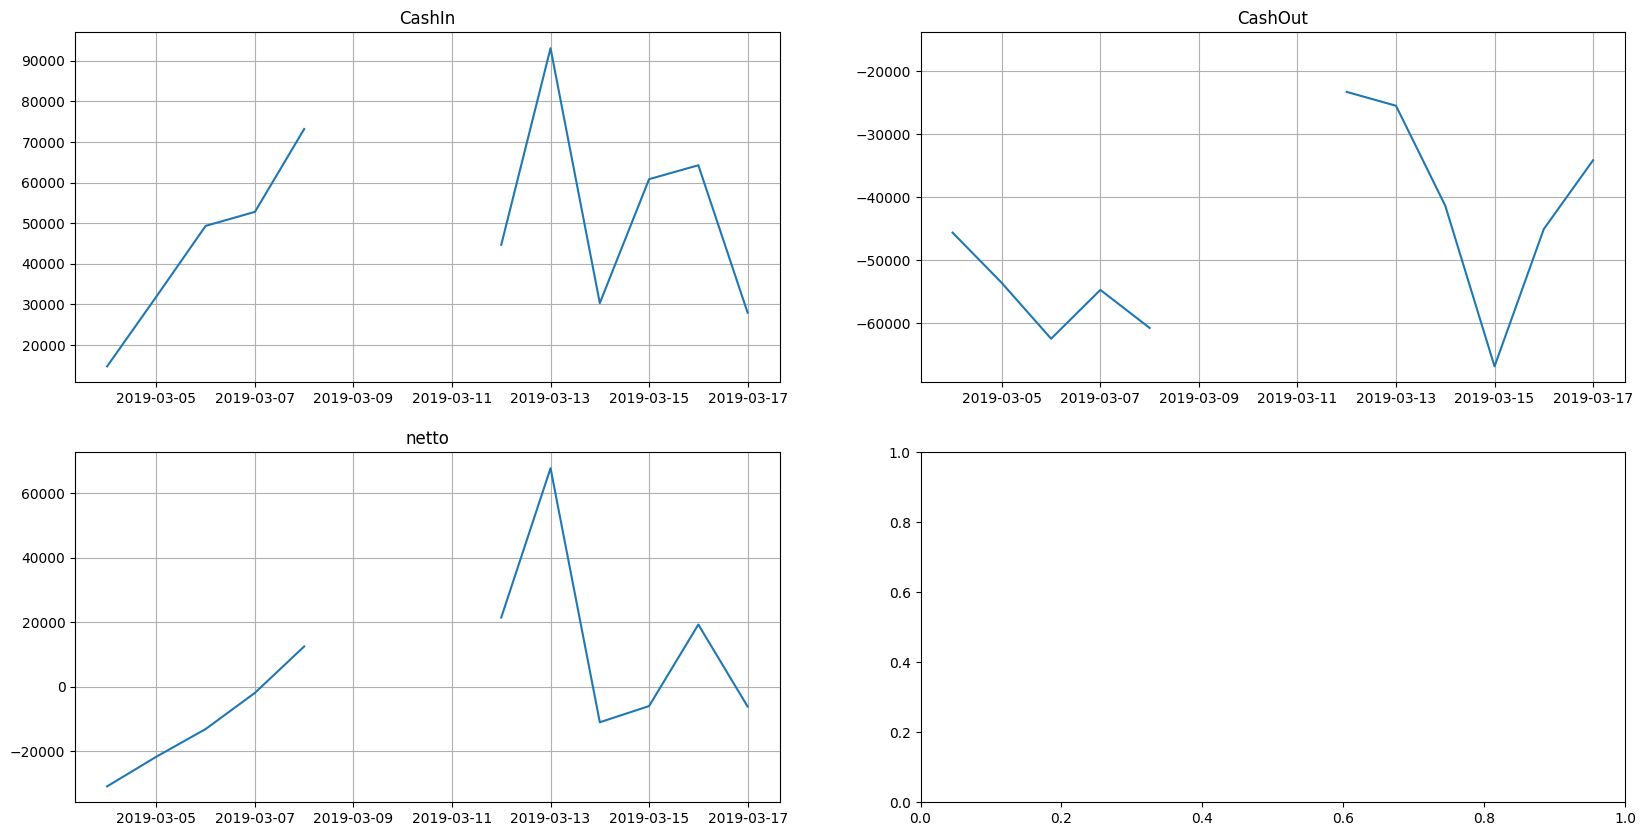

In [ ]:
ts.plot(start='2019-03-04', end='2019-03-17')

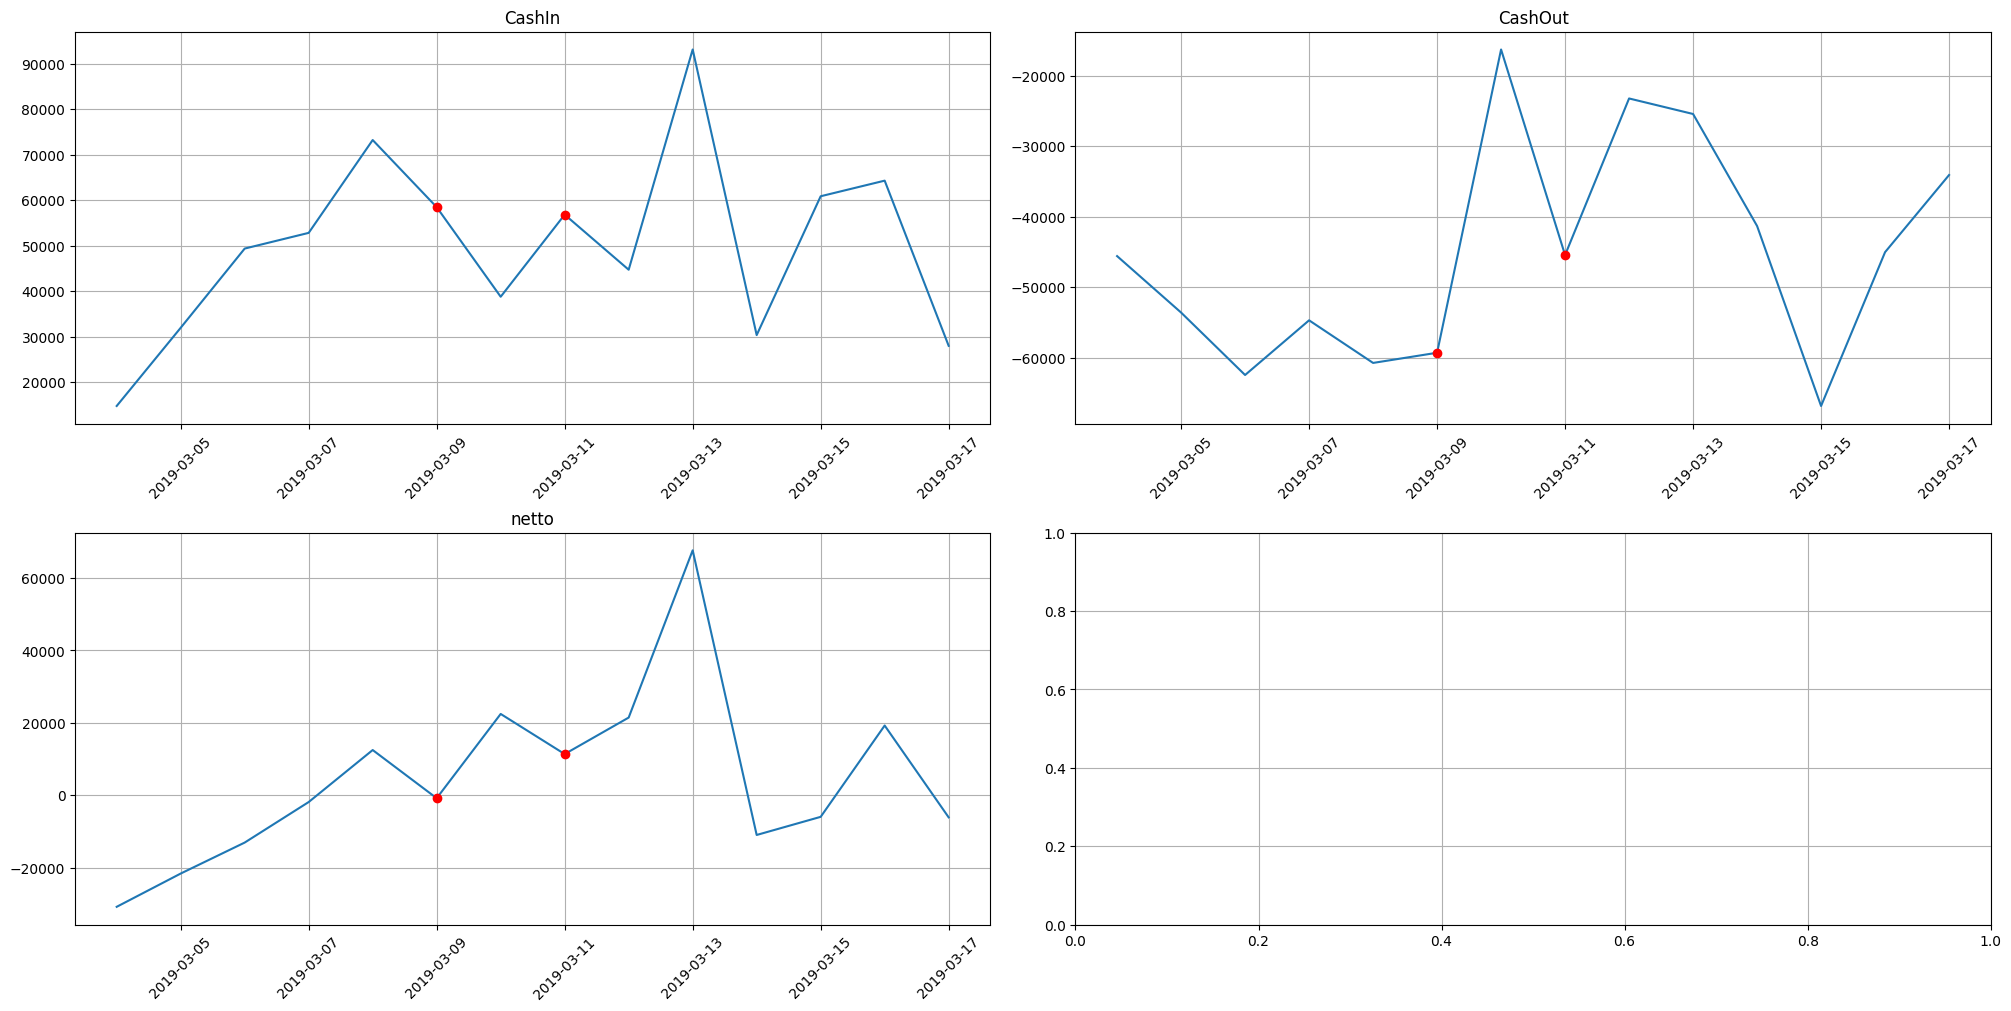

In [ ]:
imputer = TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=3)
plot_imputation(ts, imputer, start='2019-03-04', end='2019-03-17')

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

Поиск аномалий будем осуществлять на основе локальной плотности.

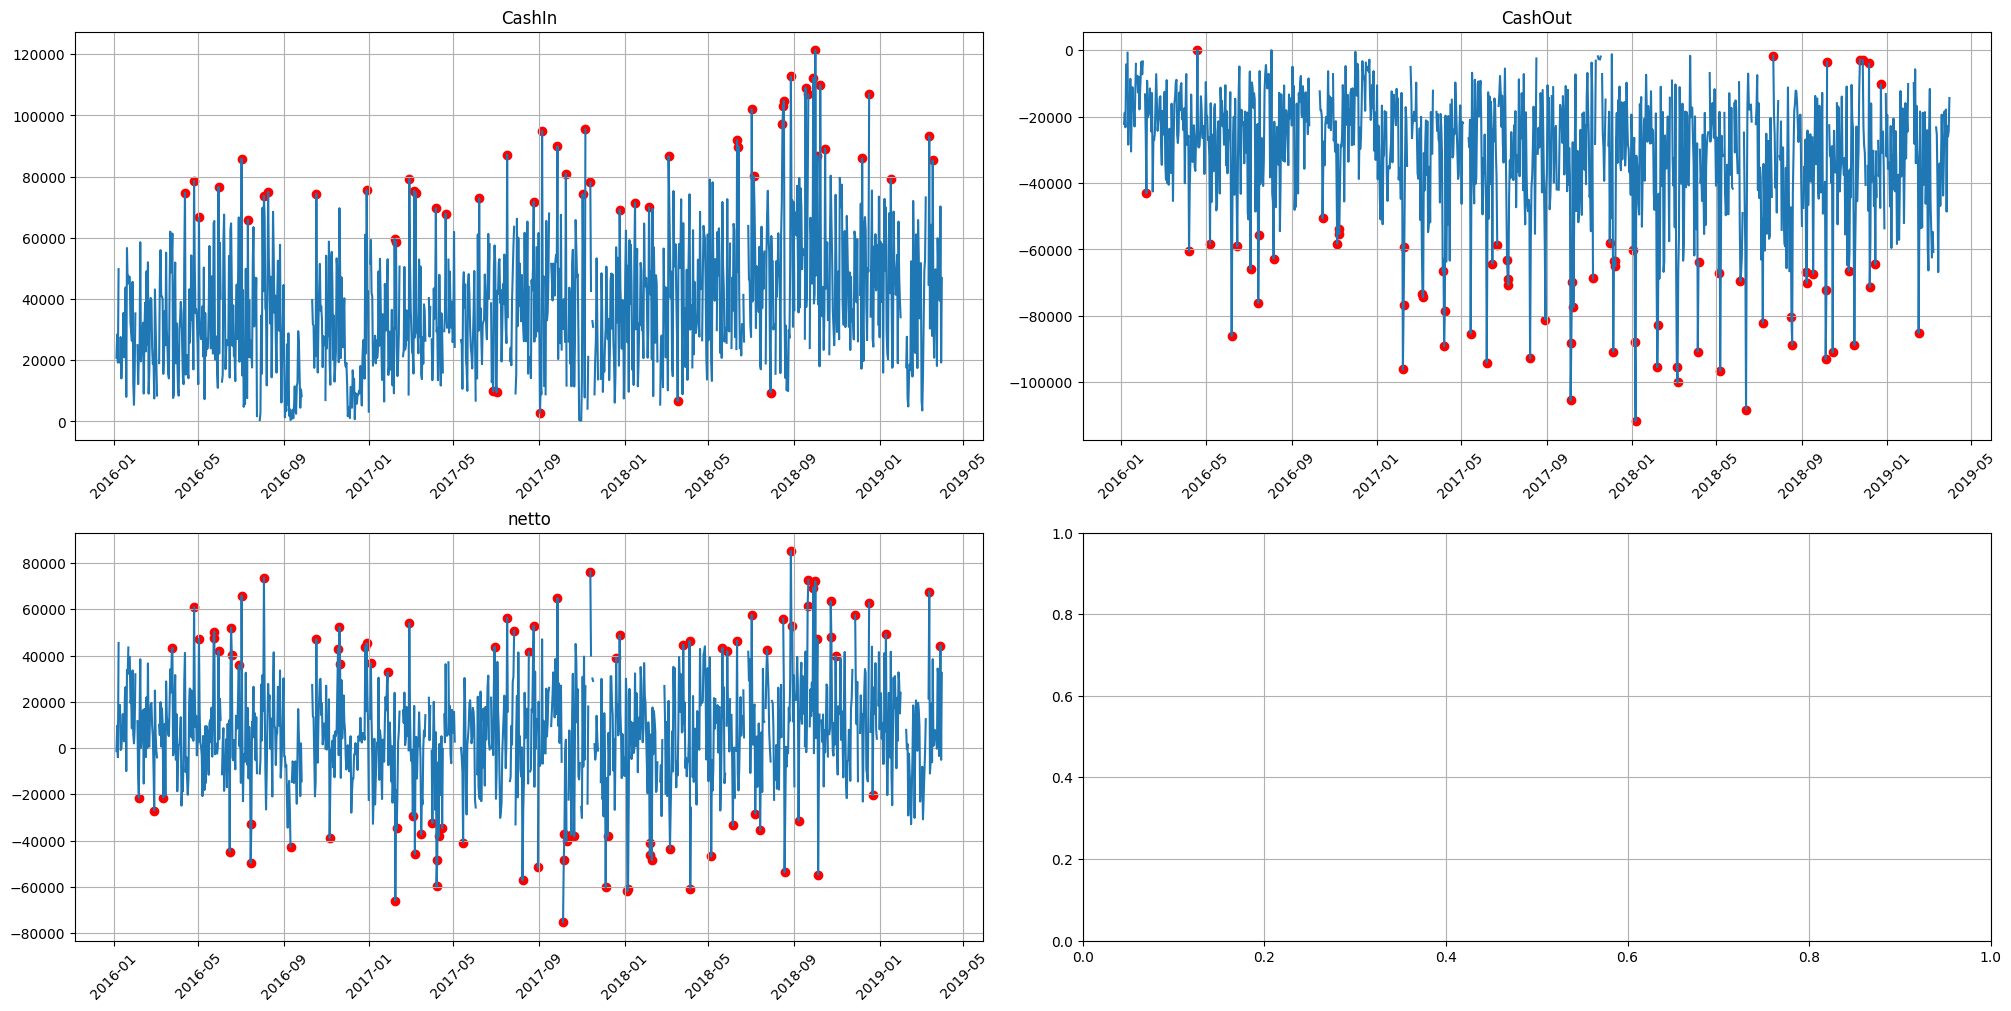

In [ ]:
plot_anomalies(ts, anomaly_dict=get_anomalies_density(ts, window_size=20, distance_coef=1, n_neighbors=6))

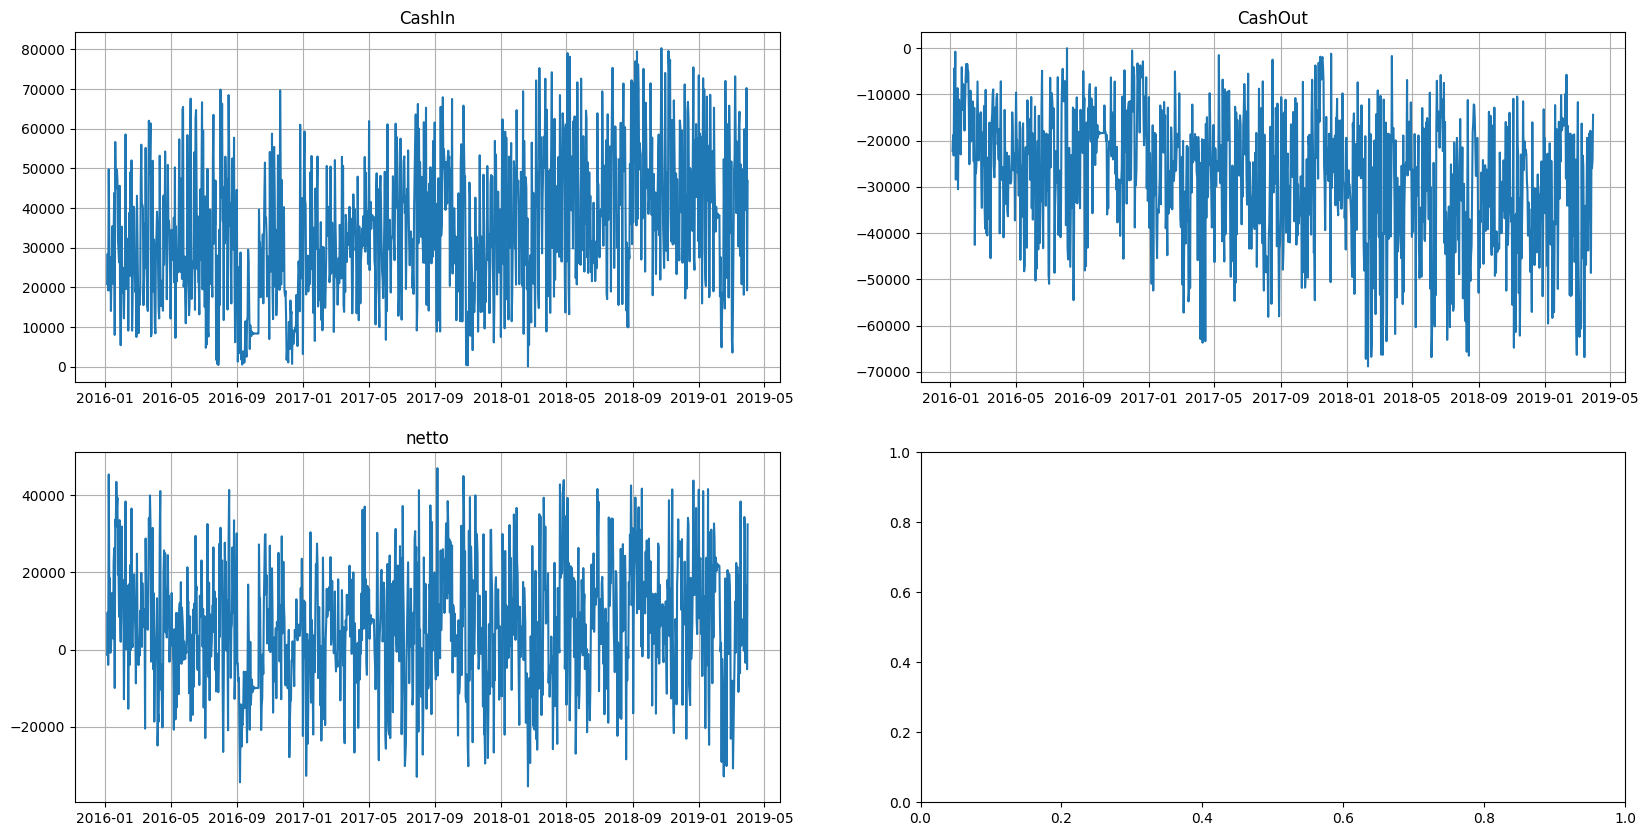

In [ ]:
outliers_remover = DensityOutliersTransform(in_column='target', window_size=20, distance_coef=1, n_neighbors=6)

transformed_ts = deepcopy(ts)
transformed_ts.fit_transform([outliers_remover, imputer])
transformed_ts.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [ ]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [ ]:
HORIZON = 5

In [ ]:
pipeline = Pipeline(
    model=ProphetModel(),
    horizon=HORIZON
)

metrics, forecast, _ = pipeline.backtest(ts=transformed_ts, metrics=[SMAPE(), MAE()], aggregate_metrics=True)

In [ ]:
metrics_smape = metrics.drop(columns=['MAE'])
metrics_smape

segment       SMAPE
0   CashIn   28.997840
1  CashOut   33.868029
2    netto  118.875278

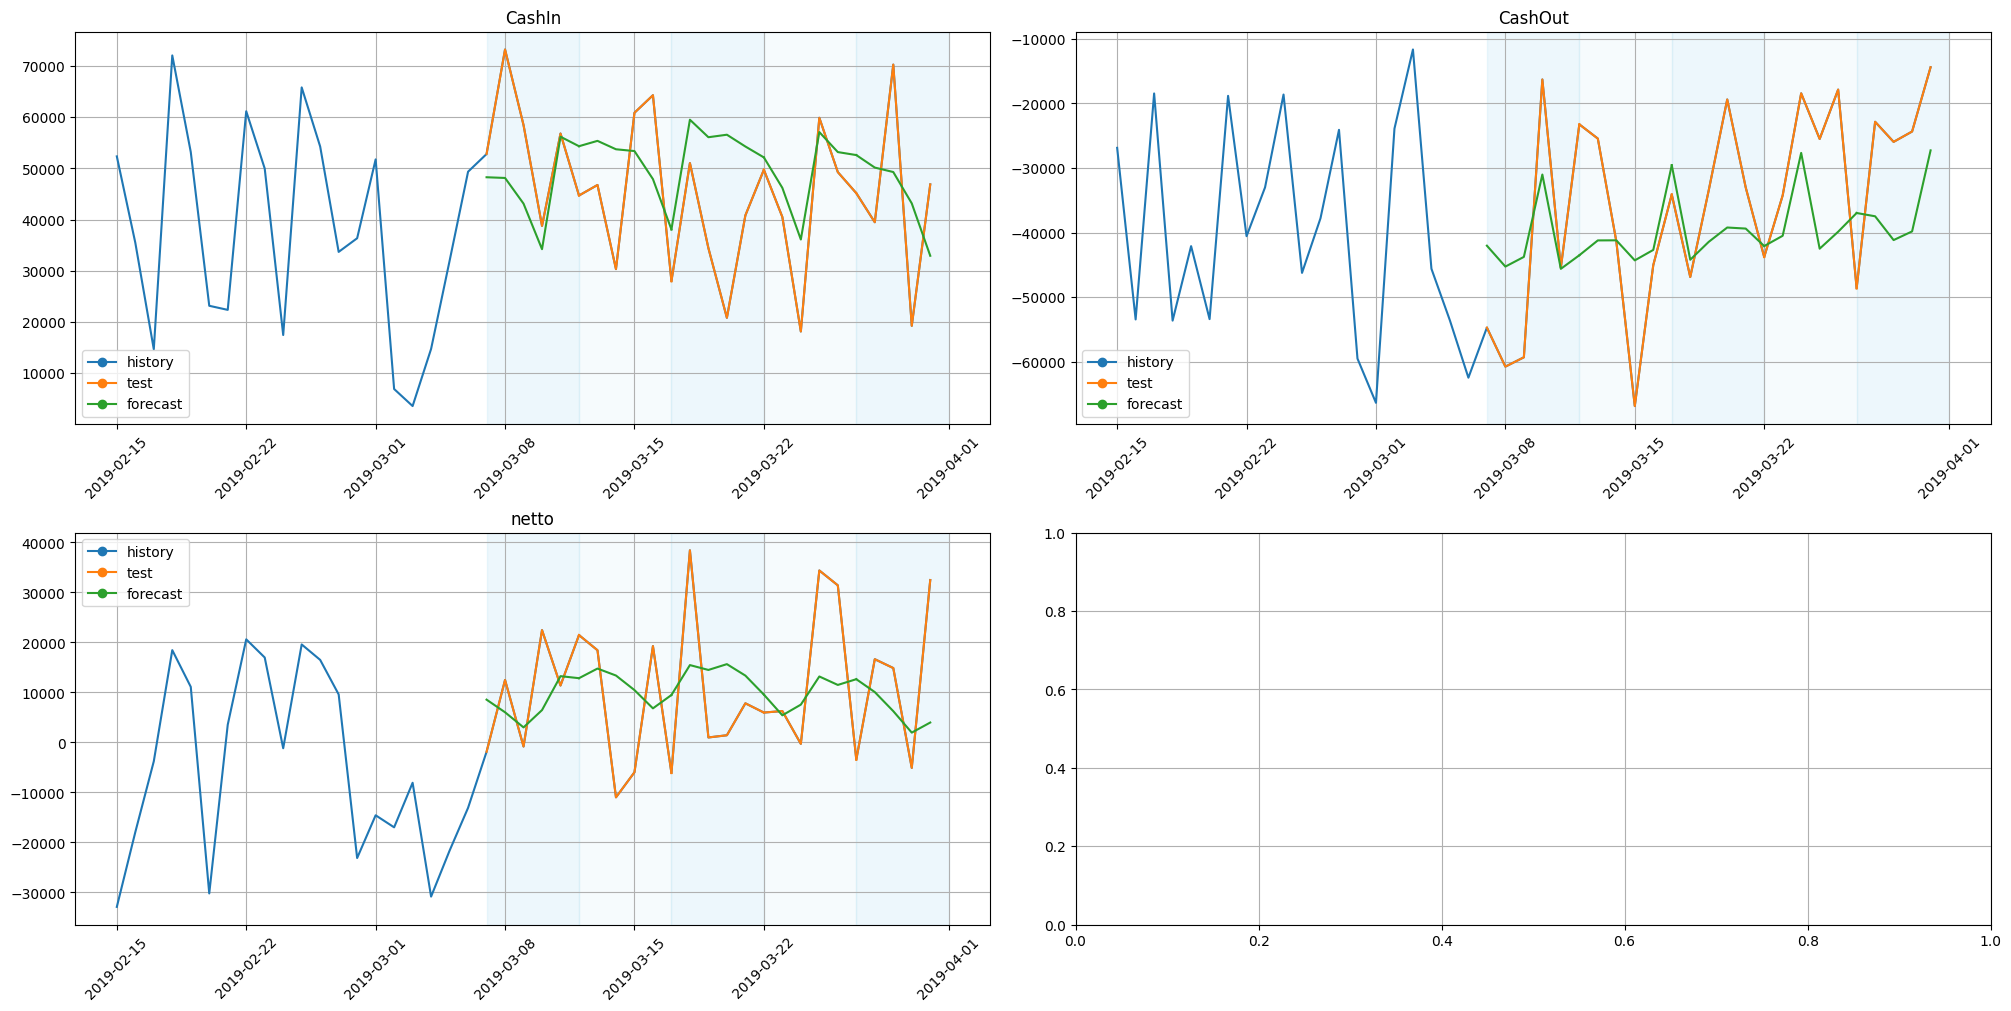

In [ ]:
plot_backtest(forecast, transformed_ts, history_len=20)

Модель сделала предположение об общем направлении тренда, но предсказанный ряд оказался слишком плавный. Также можем наблюдать смещение прогноза.

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [ ]:
metrics_mae = metrics.drop(columns=['SMAPE'])
metrics_mae

segment           MAE
0   CashIn  12589.756794
1  CashOut  11472.899777
2    netto  11845.762330

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [ ]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [ ]:
hierarchical_df = deepcopy(df)

In [ ]:
hierarchical_df['timestamp'] = pd.to_datetime(hierarchical_df['Date'])
hierarchical_df.drop(columns=['Date', 'netto'], inplace=True)
hierarchical_df = pd.melt(hierarchical_df, id_vars=['timestamp'], value_vars=['CashIn', 'CashOut'])
hierarchical_df.rename(columns={'variable' : 'components', 'value' : 'target'}, inplace=True)

In [ ]:
hierarchical_df.head()

timestamp components   target
0 2016-01-05     CashIn  20840.0
1 2016-01-06     CashIn  28460.0
2 2016-01-07     CashIn  19250.0
3 2016-01-08     CashIn  49770.0
4 2016-01-09     CashIn      NaN

In [ ]:
hierarchical_df, hierarchical_structure = TSDataset.to_hierarchical_dataset(df=hierarchical_df, level_columns=['components'])

In [ ]:
hierarchical_df.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [ ]:
hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['CashIn', 'CashOut']}, level_names = ['total', 'components'], )

In [ ]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq='D', hierarchical_structure=hierarchical_structure)

In [ ]:
hierarchical_ts.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [ ]:
reconciliator = BottomUpReconciliator(target_level='total', source_level='components')

In [ ]:
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

\begin{equation*}
    y_{netto}
    =
    \begin{bmatrix}
    1 & 1
    \end{bmatrix}
    \begin{bmatrix}
    y_{cashIn} \\ y_{cashOut}
    \end{bmatrix}
    =
    y_{cashIn} + y_{cashOut}
\end{equation*}

In [ ]:
reconciliator.aggregate(ts=hierarchical_ts).head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [ ]:
hierarchical_ts.fit_transform(
    [
        DensityOutliersTransform(in_column='target', window_size=20, distance_coef=1, n_neighbors=6),
        TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=3)
    ]
)

In [ ]:
pipeline_hierarchical = HierarchicalPipeline(
    model=ProphetModel(),
    horizon=HORIZON,
    reconciliator=reconciliator,
)

metrics_hierarchical, forecast_hierarchical, _ = pipeline_hierarchical.backtest(ts=hierarchical_ts, metrics=[SMAPE(), MAE()], aggregate_metrics=True)

In [ ]:
metrics_hierarchical

segment       SMAPE           MAE
0   total  127.344346  12470.940569

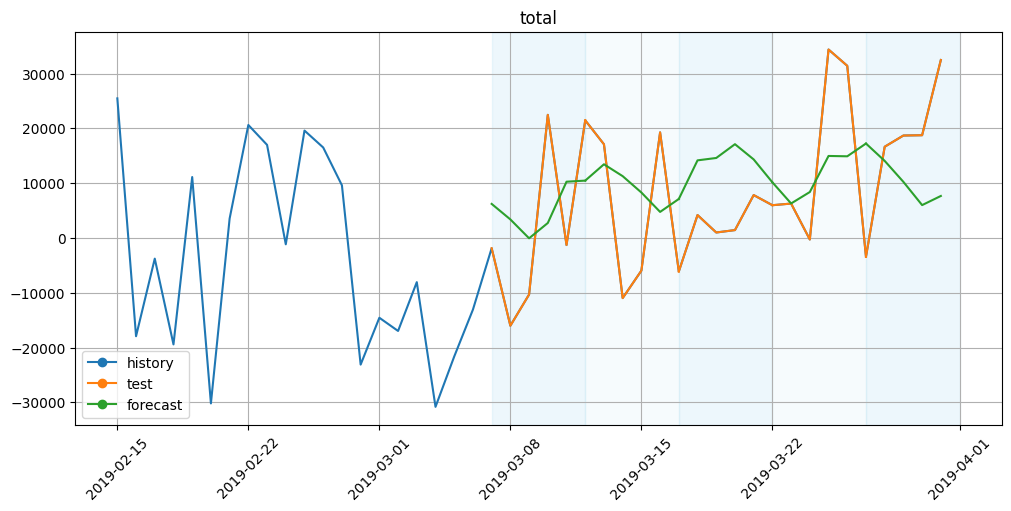

In [ ]:
plot_backtest(forecast_hierarchical, hierarchical_ts.get_level_dataset(target_level='total'), history_len=20)

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [ ]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot, get_residuals, plot_trend
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import (STLTransform, LagTransform, SegmentEncoderTransform,
                             LinearTrendTransform, MeanTransform)

Наиболее значимыми лагами являются лаг 1 для всех рядов, лаги 7, 14, 21 для `CashIn`, лаги 2, 3, 4 для `CashOut`, 2 для `netto`. Добавим лаги в `CatBoost` модель.

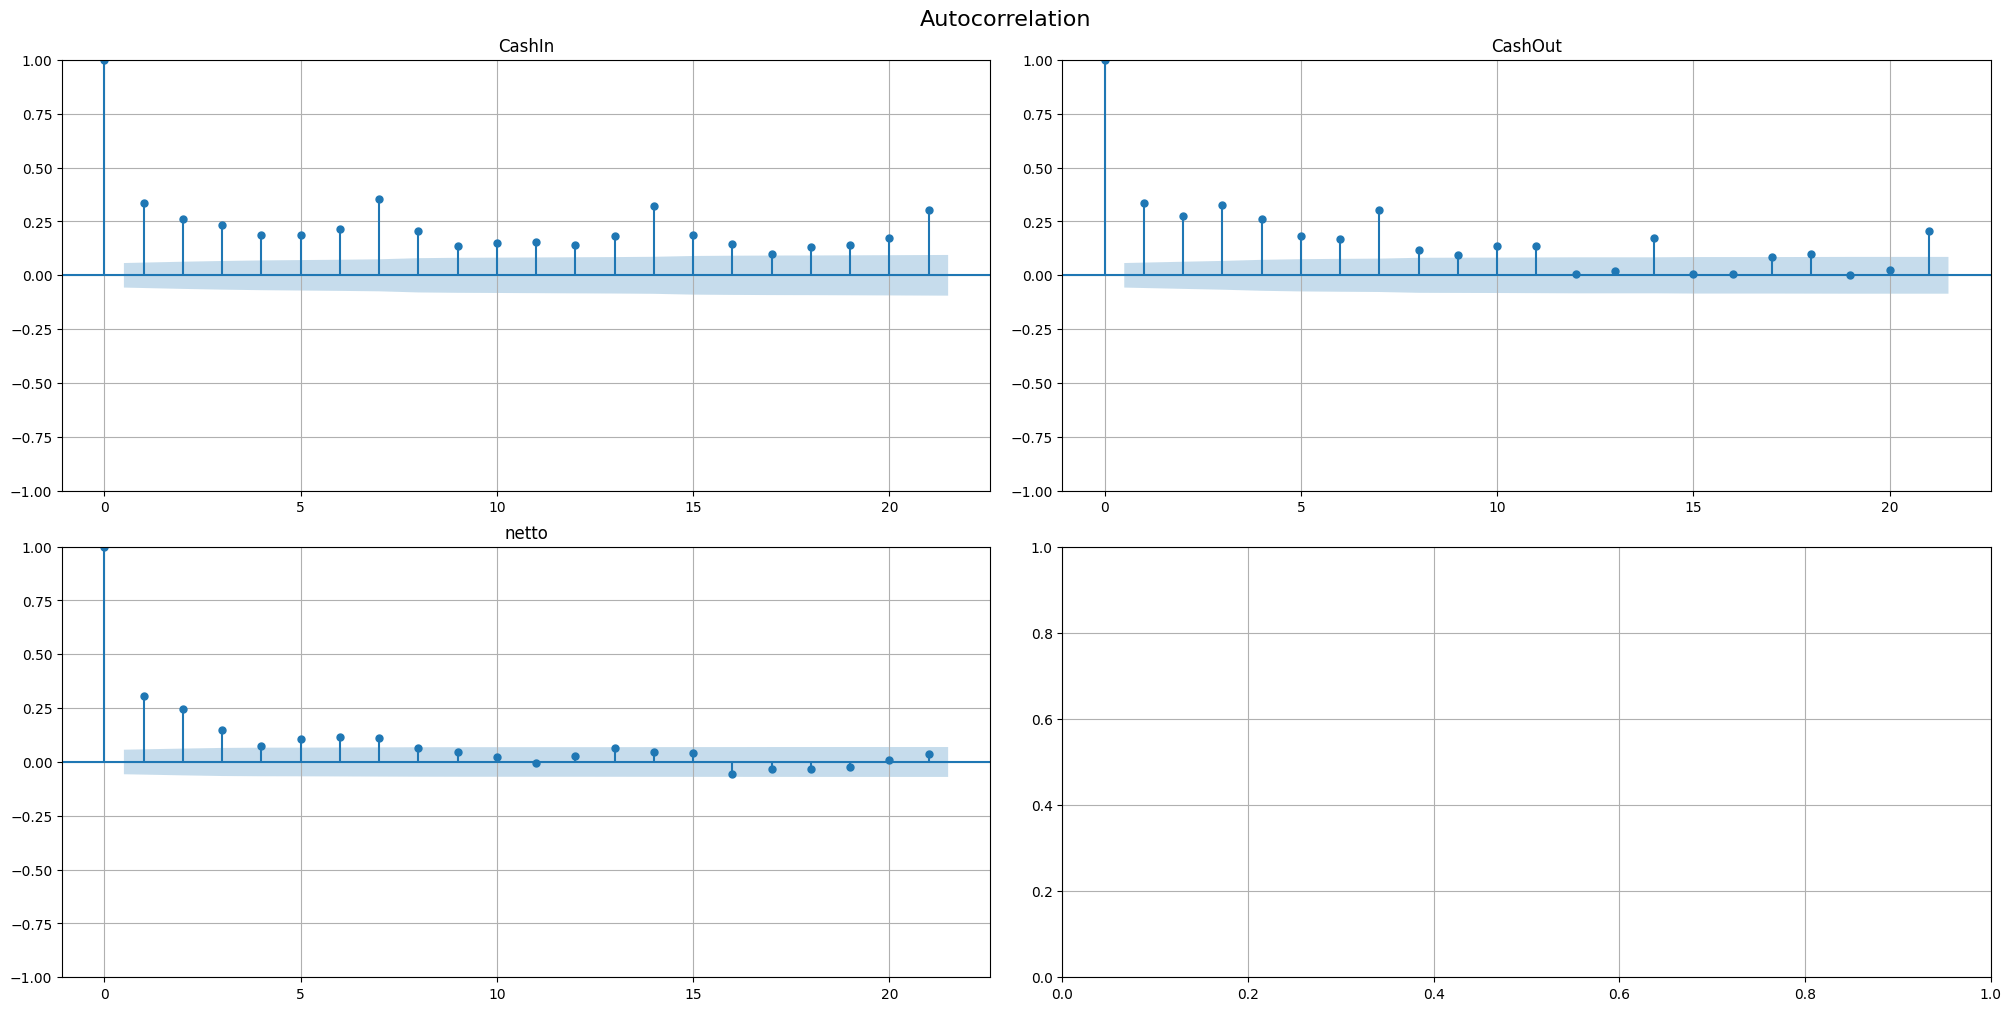

In [ ]:
sample_acf_plot(transformed_ts)

Смоделируем тренд и также добавим в модель.

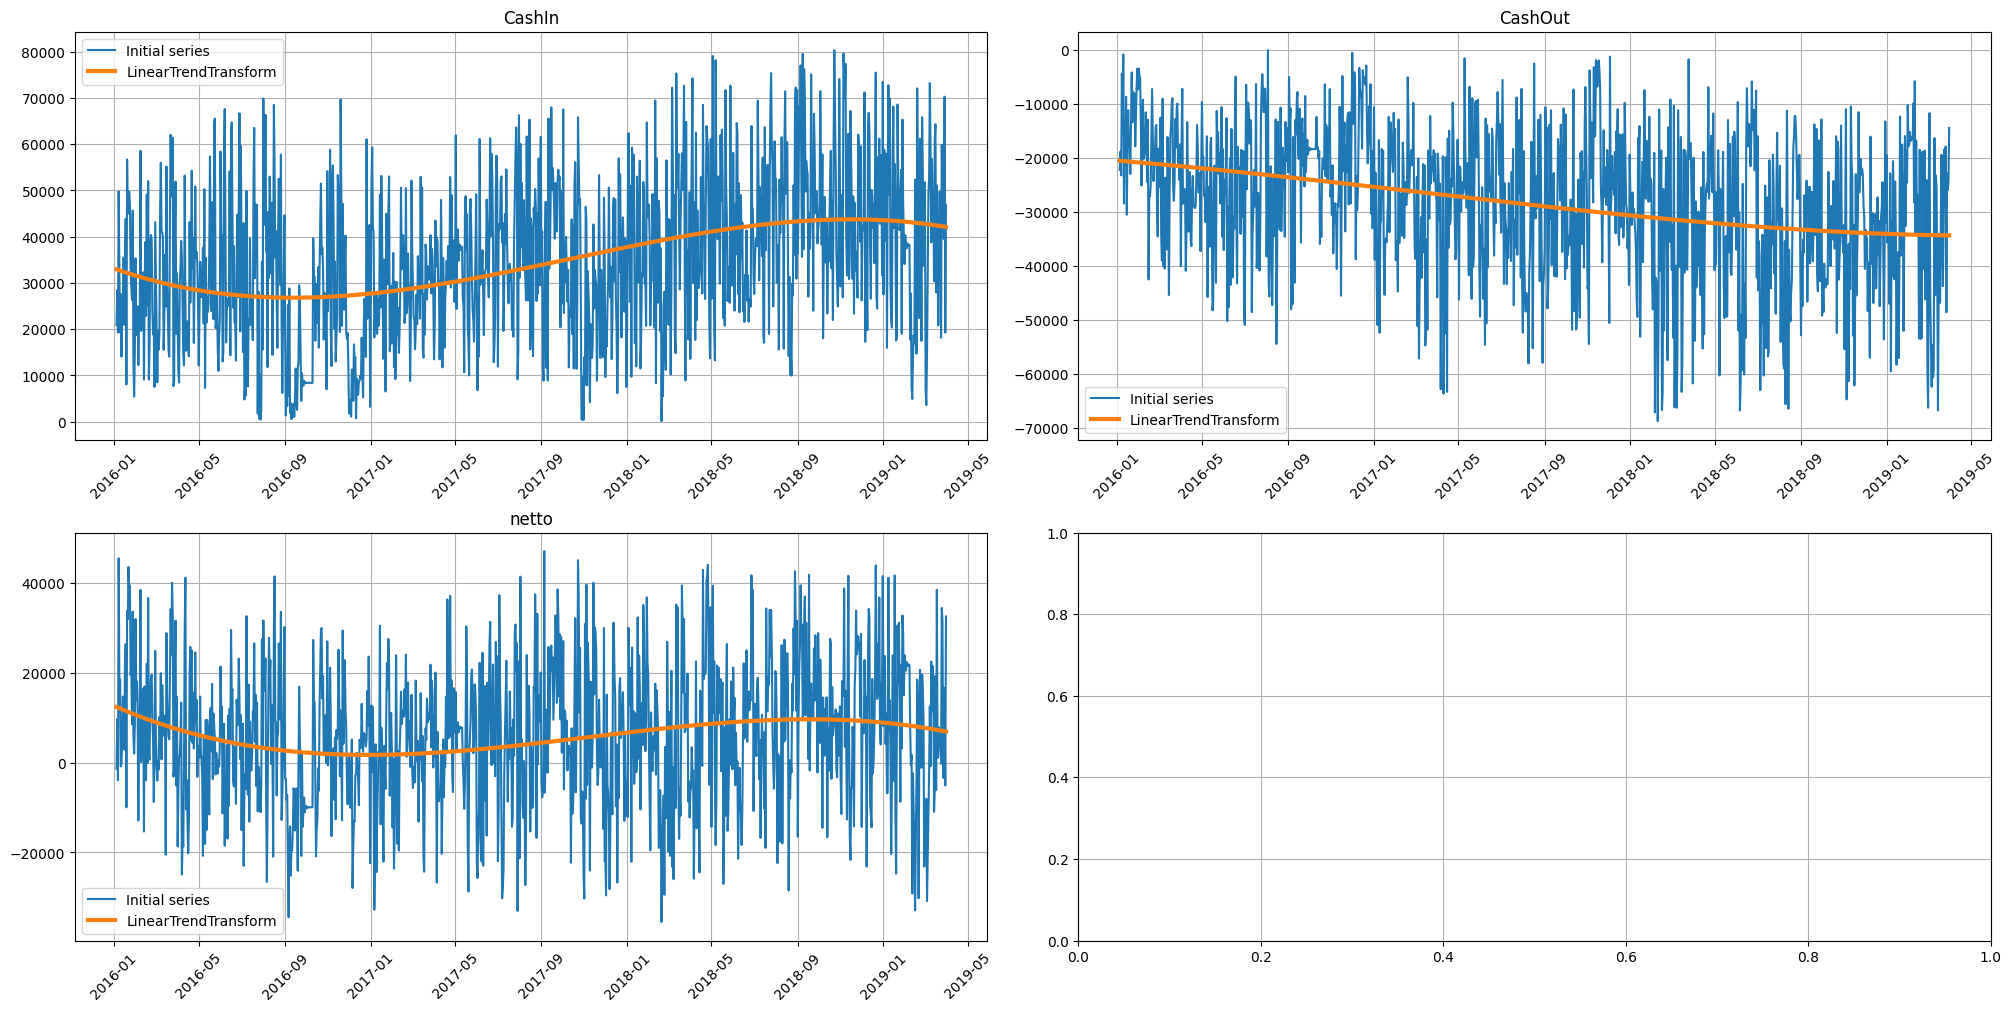

In [ ]:
plot_trend(
    ts=transformed_ts,
    trend_transform=[LinearTrendTransform(in_column='target', poly_degree=3)]
)

Также добавим `STLTransform` с периодом сезонности 7 в пайплайн.

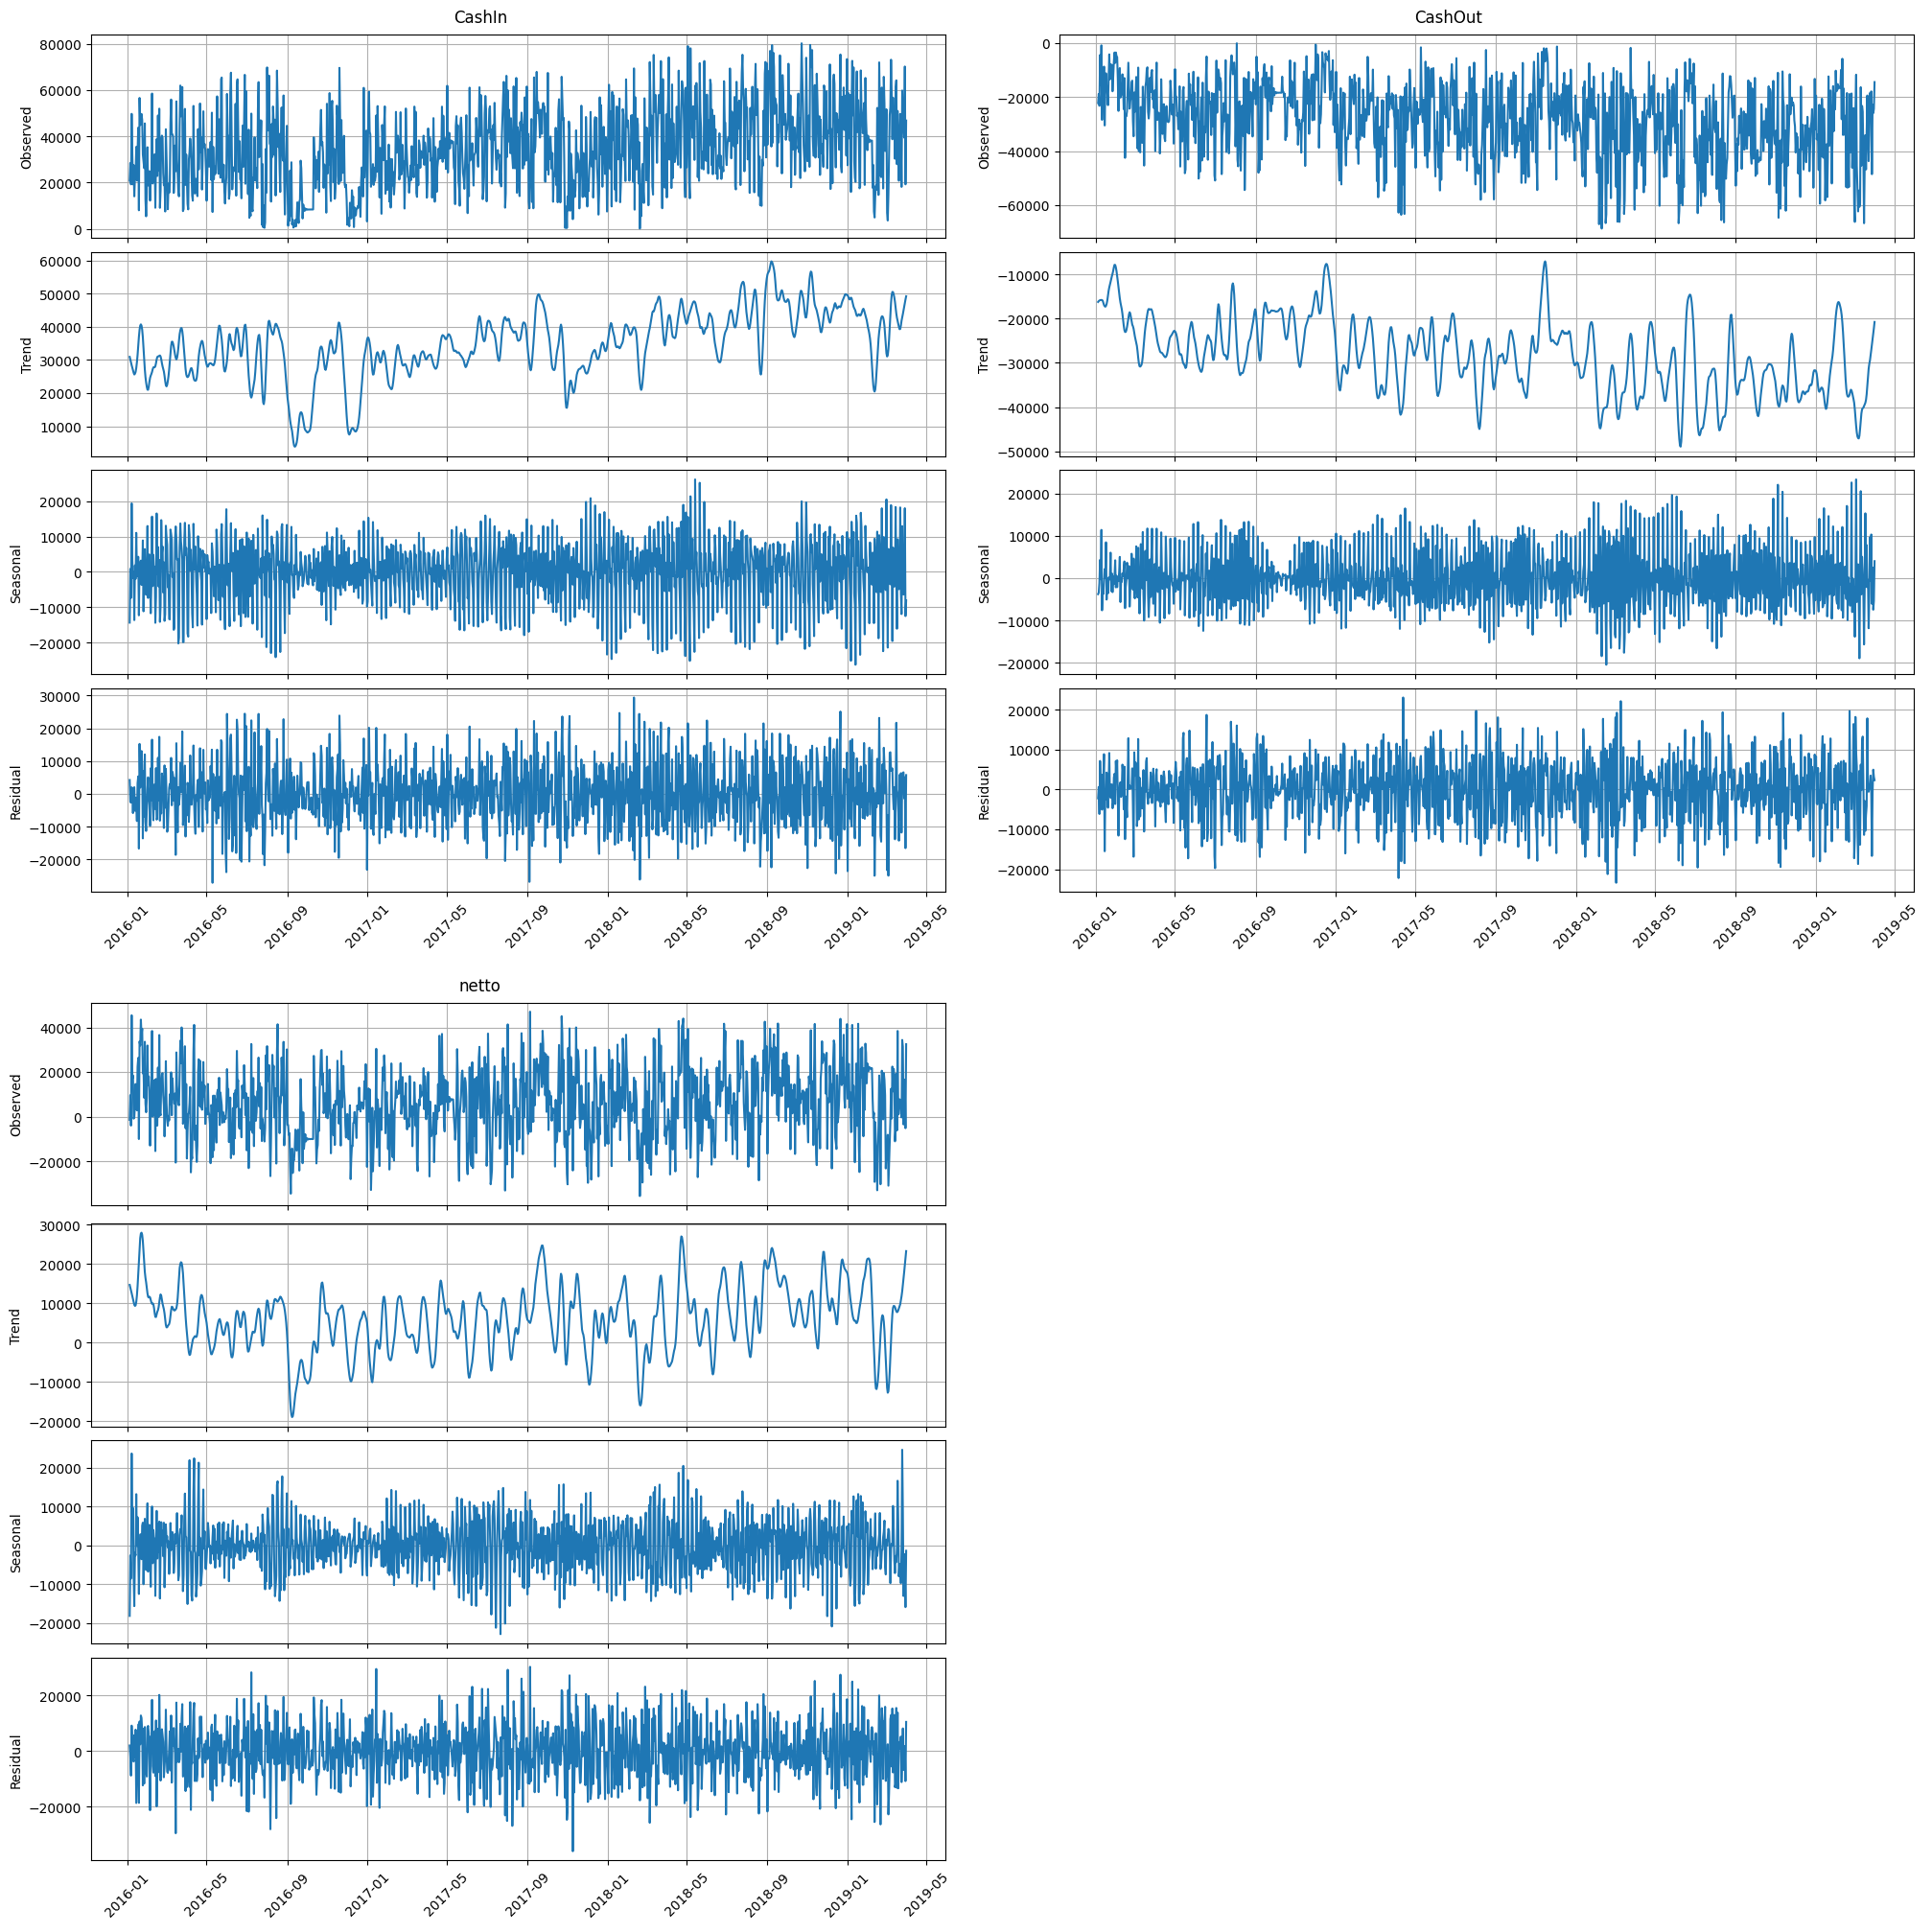

In [ ]:
stl_plot(transformed_ts, period=7)

In [ ]:
pipeline_catboost = Pipeline(
    transforms=[
        LinearTrendTransform(in_column='target', poly_degree=3),
        LagTransform(in_column='target', lags=[1, 2, 3, 4, 7, 14, 21]),
        SegmentEncoderTransform(),
        STLTransform(in_column='target', period=7),
        MeanTransform(in_column='target', window=3)
    ],
    model=CatBoostMultiSegmentModel(),
    horizon=HORIZON
)

In [ ]:
metrics_catboost, forecast_catboost, _ = pipeline_catboost.backtest(ts=transformed_ts, metrics=[SMAPE()], aggregate_metrics=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.7s finished


In [ ]:
metrics_catboost

segment       SMAPE
0   CashIn   45.316084
1  CashOut   48.696570
2    netto  127.604482

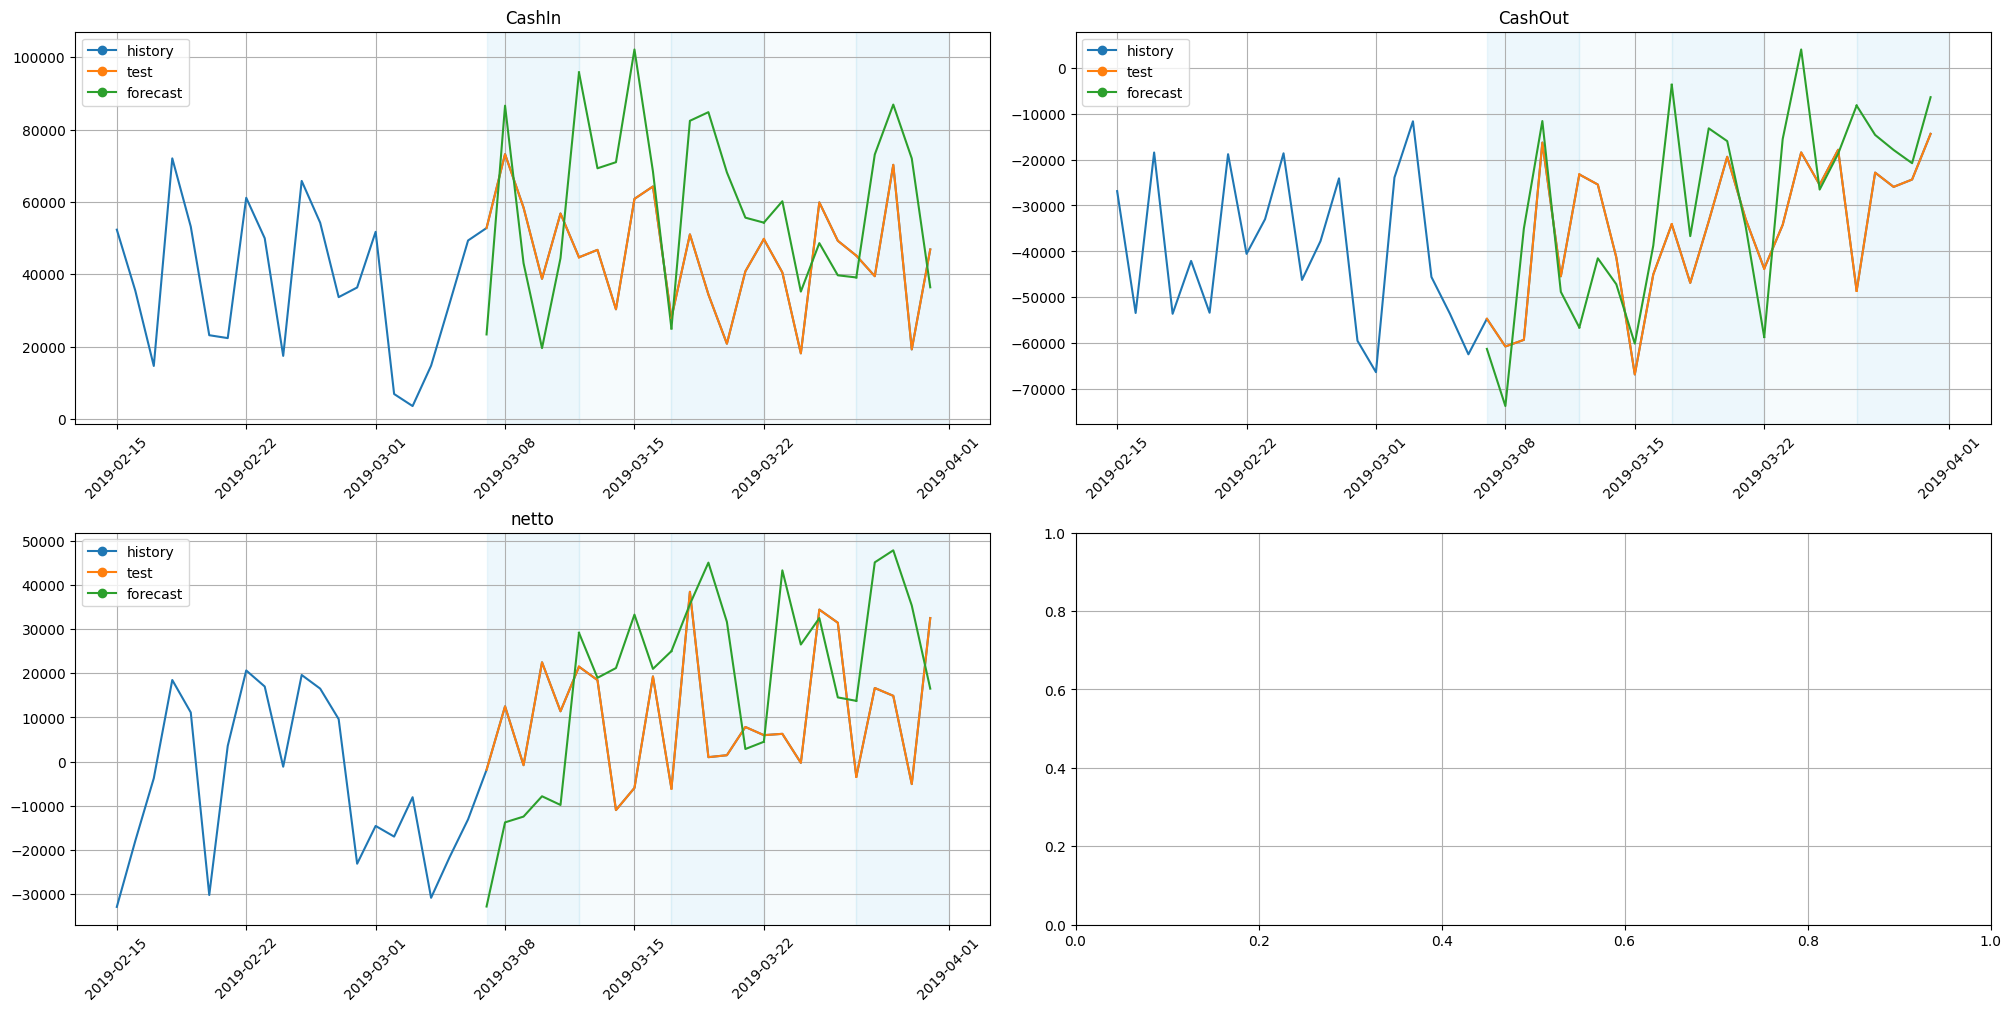

In [ ]:
plot_backtest(forecast_catboost, transformed_ts, history_len=20)

Уже лучше! Модель предсказывает общий тренд и при этом учитывает особенности ряда.

Определим параметры модели `ARIMA`. Начнём с параметра `d` $-$ порядок дифференцирования ряда, при котором он становится стационарным. В нашем случае можем судить, что ряды практически стабильны при `d=1`.

In [ ]:
from itertools import product

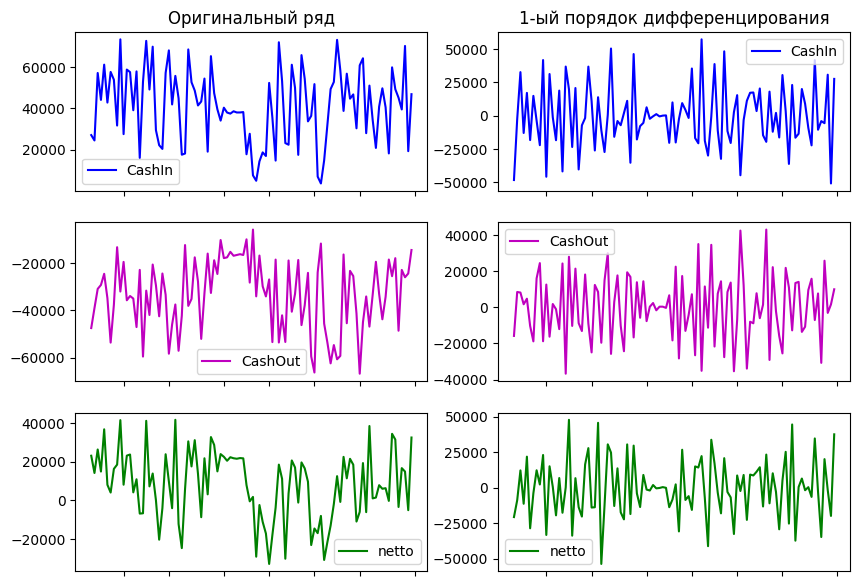

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 7), sharex=True)

for ax, segment, label, color in zip(list(product([0, 1, 2], [0, 1])),
                                    ['CashIn'] * 2 + ['CashOut'] * 2 + ['netto'] * 2,
                                    ['orig', '1st'] * 3,
                                    ['b'] * 2 + ['m'] * 2 + ['g'] * 2):
    if label == 'orig':
      axes[ax[0], ax[1]].plot(transformed_ts.to_pandas(False)[-100:][segment],
                              label=segment,
                              color=color)
    else:
      axes[ax[0], ax[1]].plot(transformed_ts.to_pandas(False).diff()[-100:][segment],
                              label=segment,
                              color=color)
    axes[ax[0], ax[1]].set_xticklabels([])
    axes[ax[0], ax[1]].legend()

axes[0, 0].set_title('Оригинальный ряд')
axes[0, 1].set_title('1-ый порядок дифференцирования')

plt.show()

In [ ]:
diff_ts = TSDataset(transformed_ts.to_pandas(False).diff(), freq='D')

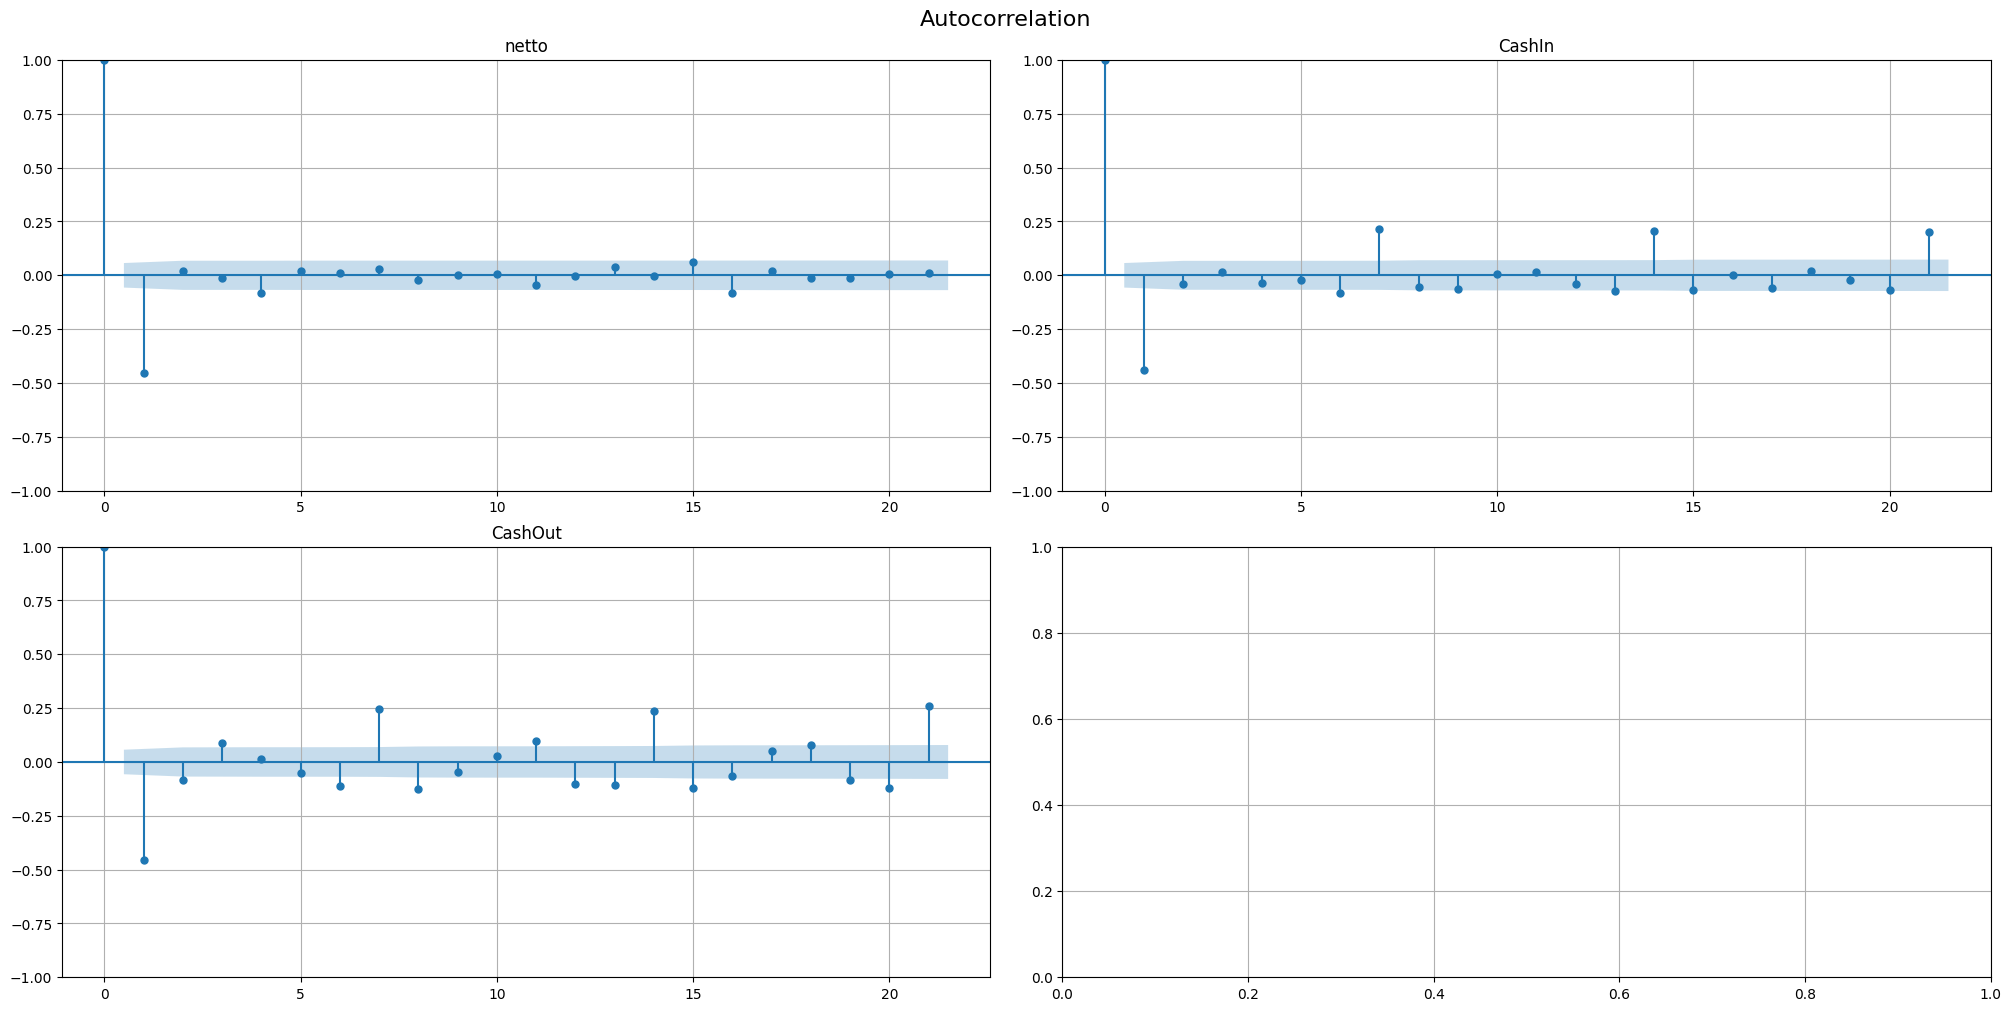

In [ ]:
sample_acf_plot(diff_ts)

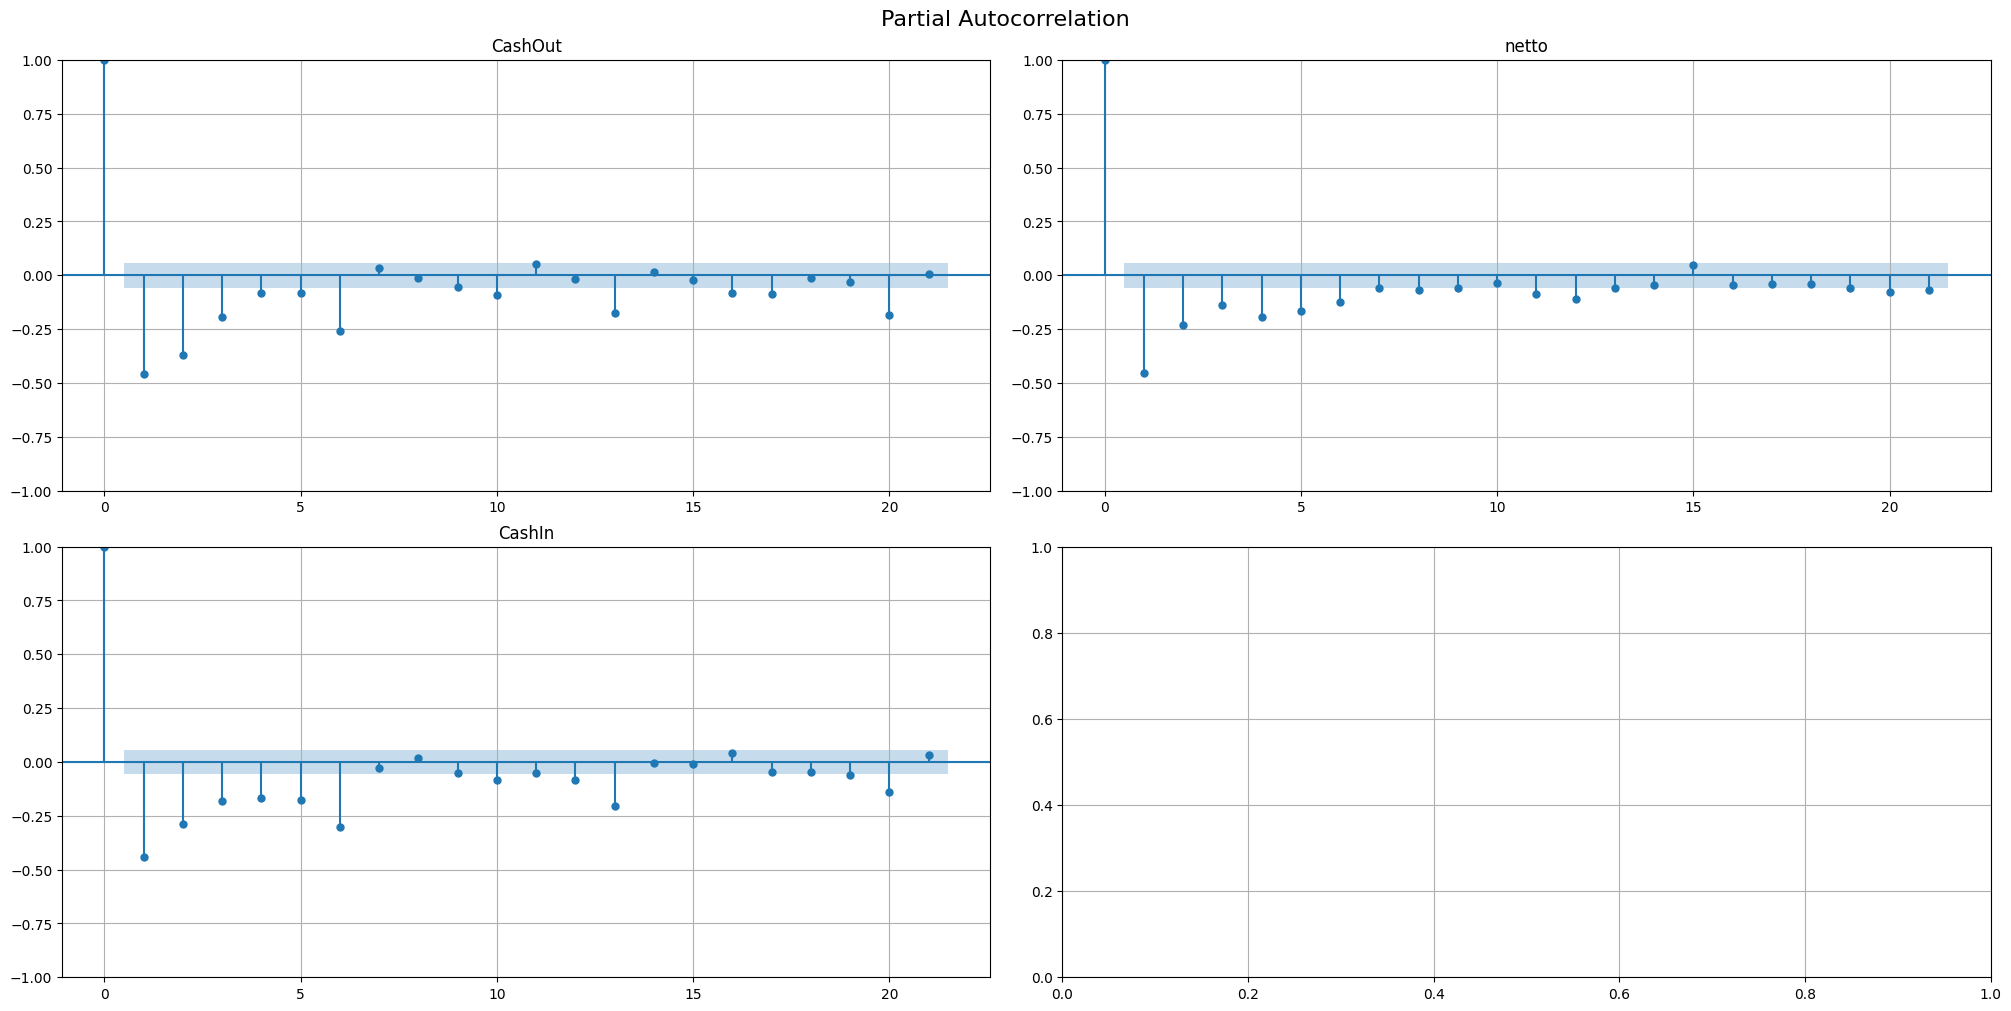

In [ ]:
sample_pacf_plot(diff_ts)

На обоих графиках заметна существенная корреляция для лага 1, значит, `p=q=1`.

In [ ]:
pipeline_arima = Pipeline(
    model=AutoARIMAModel(order=(1, 1, 1)),
    horizon=HORIZON
)

In [ ]:
metrics_arima, forecast_arima, _ = pipeline_arima.backtest(ts=transformed_ts, metrics=[SMAPE()], aggregate_metrics=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.8min finished


In [ ]:
metrics_arima

segment       SMAPE
0   CashIn   28.219259
1  CashOut   32.252437
2    netto  114.866855

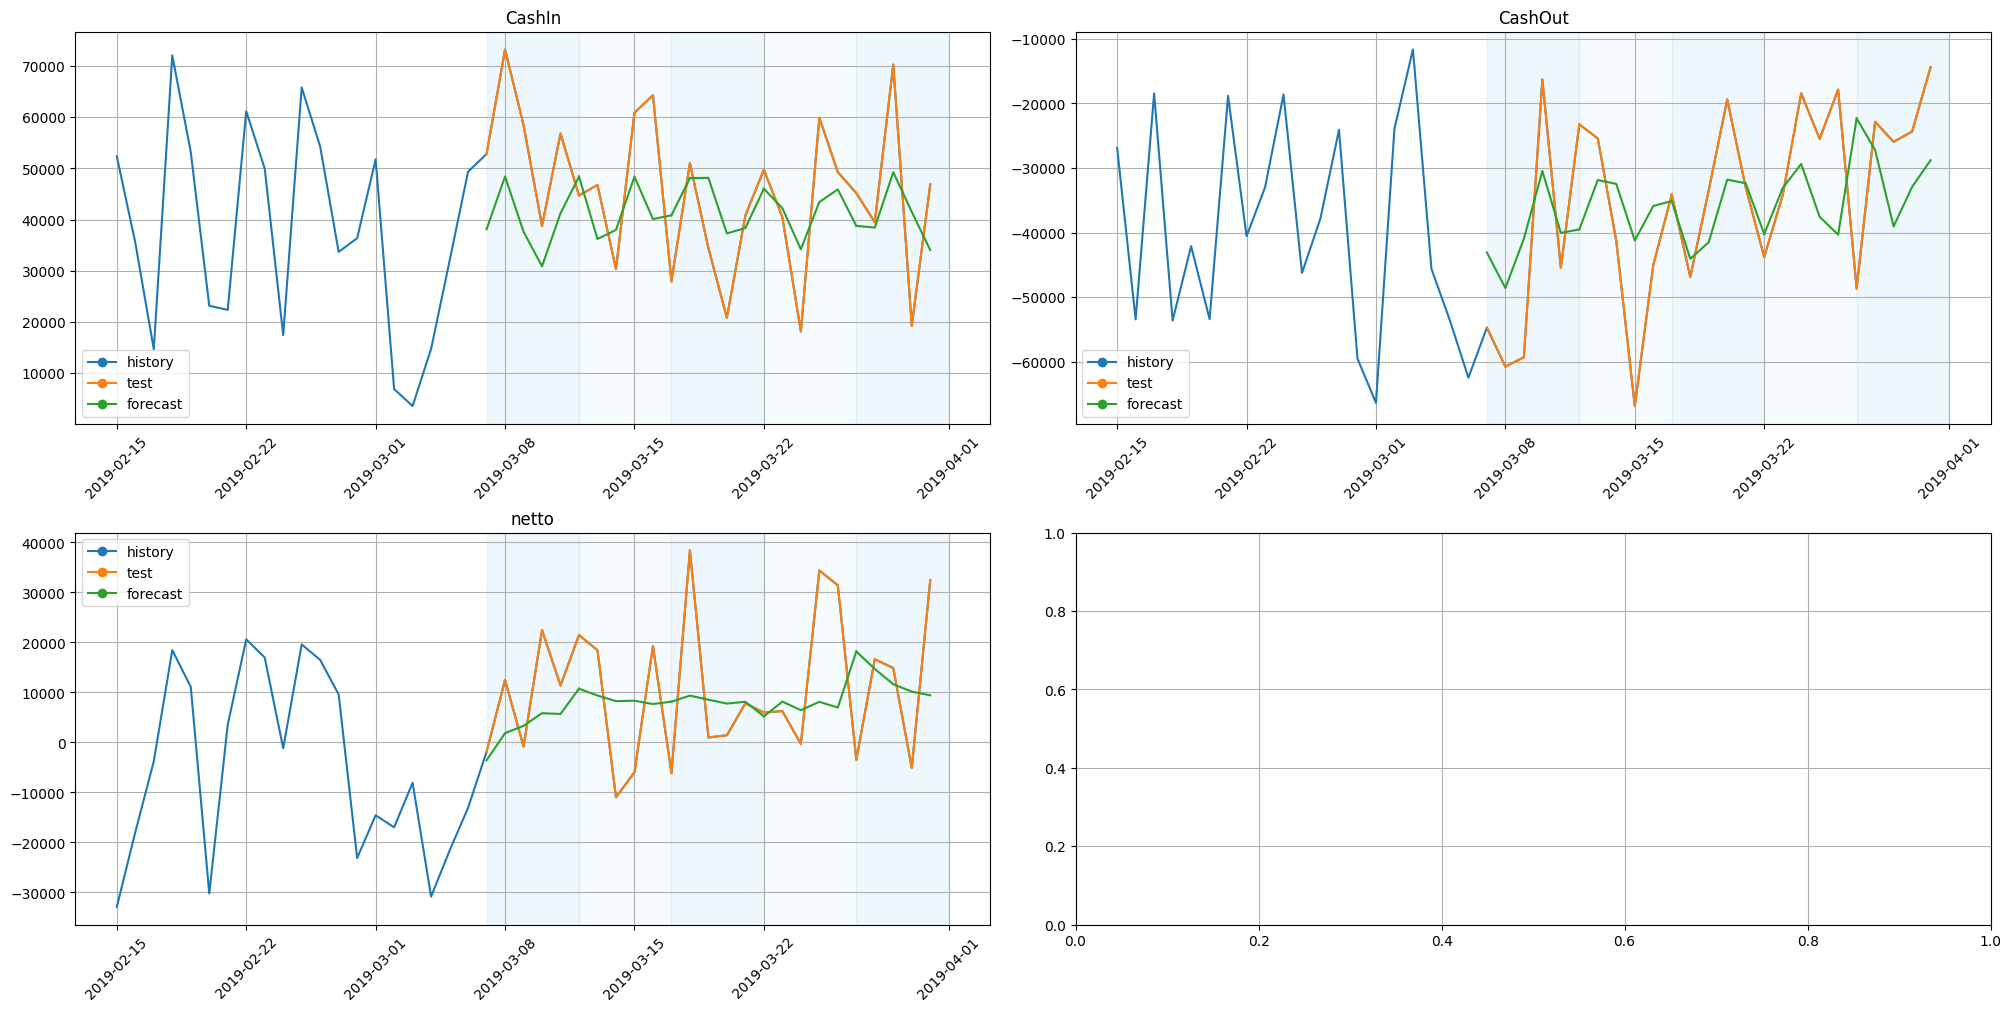

In [ ]:
plot_backtest(forecast_arima, transformed_ts, history_len=20)

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
auto_regressive_pipeline = AutoRegressivePipeline(
    transforms=[
        LinearTrendTransform(in_column='target', poly_degree=3),
        LagTransform(in_column='target', lags=[i for i in range(1, 1 + 21)]),
        SegmentEncoderTransform(),
        STLTransform(in_column='target', period=7),
        MeanTransform(in_column='target', window=3)
    ],
    model=CatBoostMultiSegmentModel(),
    horizon=HORIZON,
    step=1
)

metrics_recursive, forecast_recursive, _ = auto_regressive_pipeline.backtest(ts=transformed_ts, metrics=[SMAPE()], aggregate_metrics=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   47.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.1s finished


In [ ]:
metrics_recursive

segment       SMAPE
0   CashIn   40.752714
1  CashOut   47.416574
2    netto  135.110397

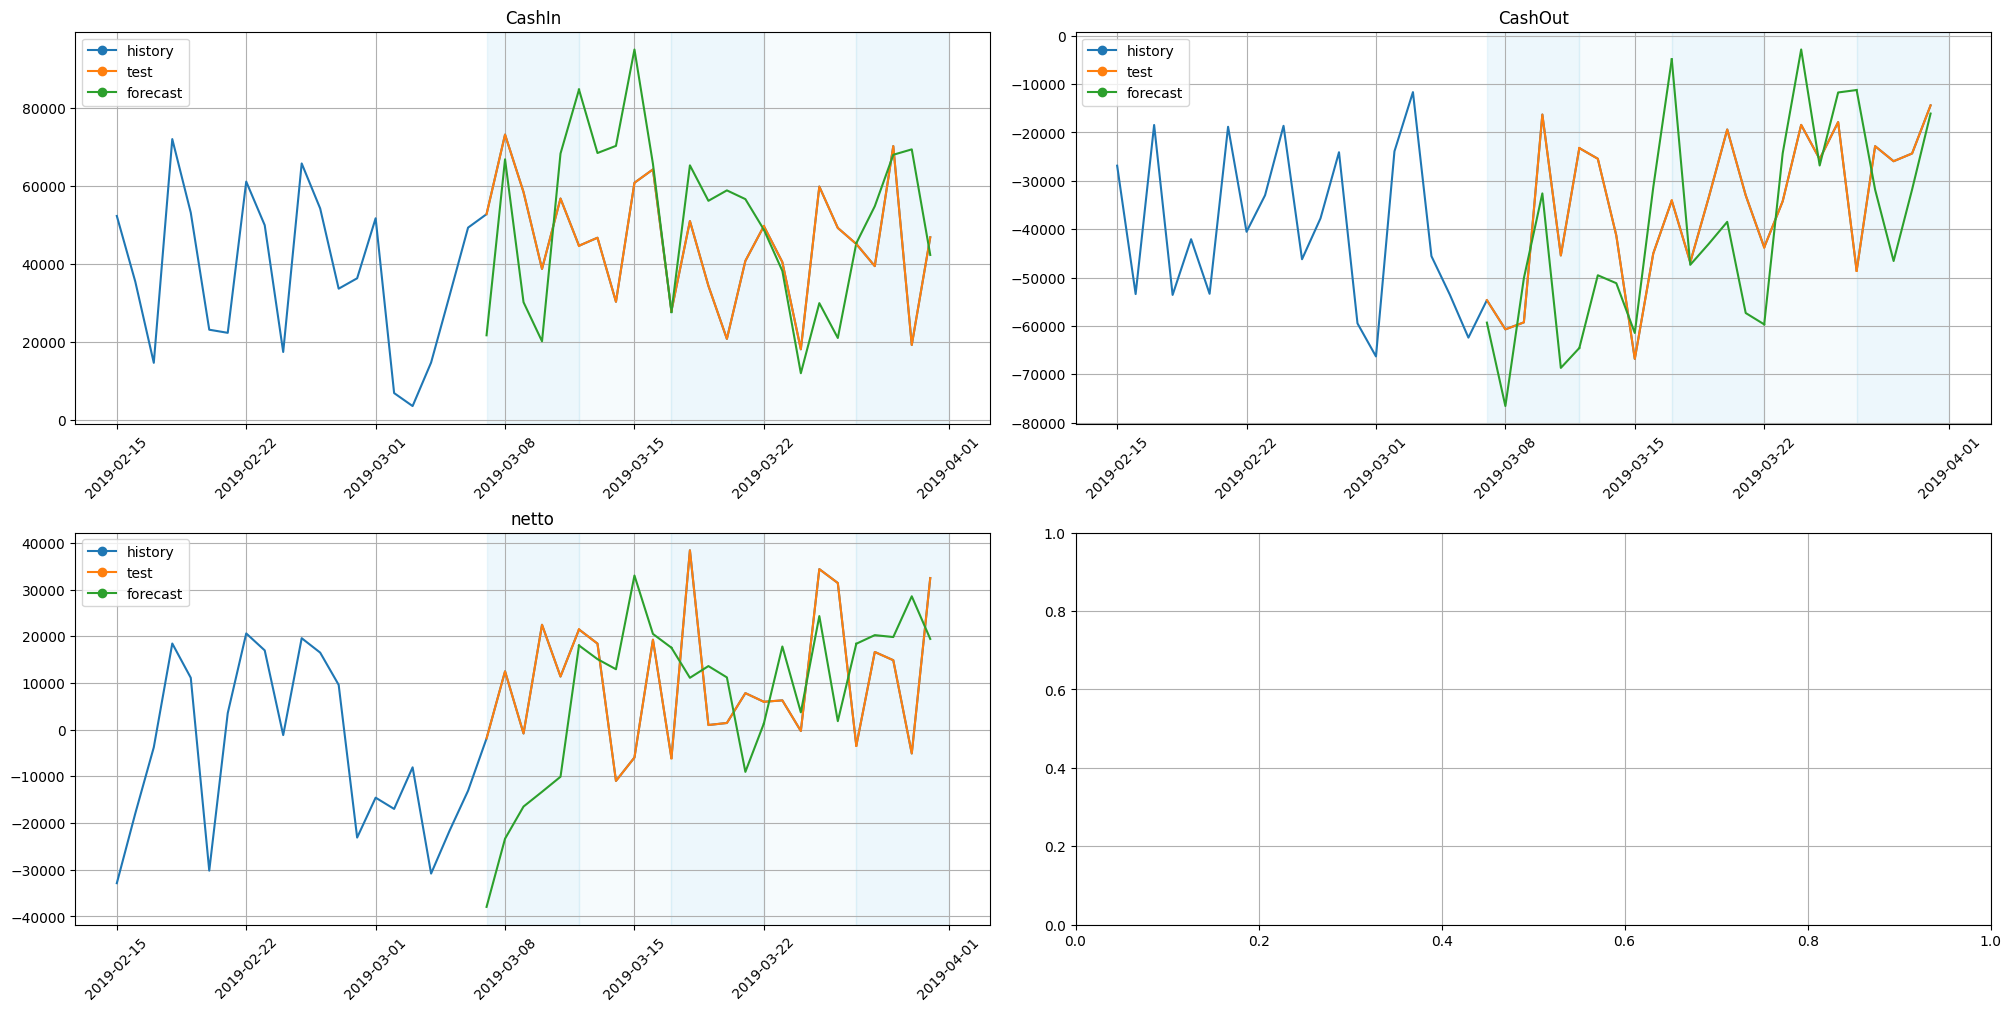

In [ ]:
plot_backtest(forecast_recursive, transformed_ts, history_len=20)

In [ ]:
pipelines = assemble_pipelines(
    models=[CatBoostMultiSegmentModel(), CatBoostMultiSegmentModel()],
    transforms=[
        LinearTrendTransform(in_column='target', poly_degree=3),
        [
            LagTransform(in_column='target', lags=[i for i in range(5, 5 + 21)]),
            LagTransform(in_column='target', lags=[i for i in range(10, 10 + 21)])
        ],
        SegmentEncoderTransform(),
        STLTransform(in_column='target', period=7),
        MeanTransform(in_column='target', window=3)
    ],
    horizons=[5, 10]
)

In [ ]:
direct_ensemble = DirectEnsemble(pipelines=pipelines)

metrics_direct, forecast_direct, _ = direct_ensemble.backtest(ts=transformed_ts, metrics=[SMAPE()], aggregate_metrics=True)

In [ ]:
metrics_direct

segment       SMAPE
0   CashIn   51.992437
1  CashOut   50.179748
2    netto  141.720552

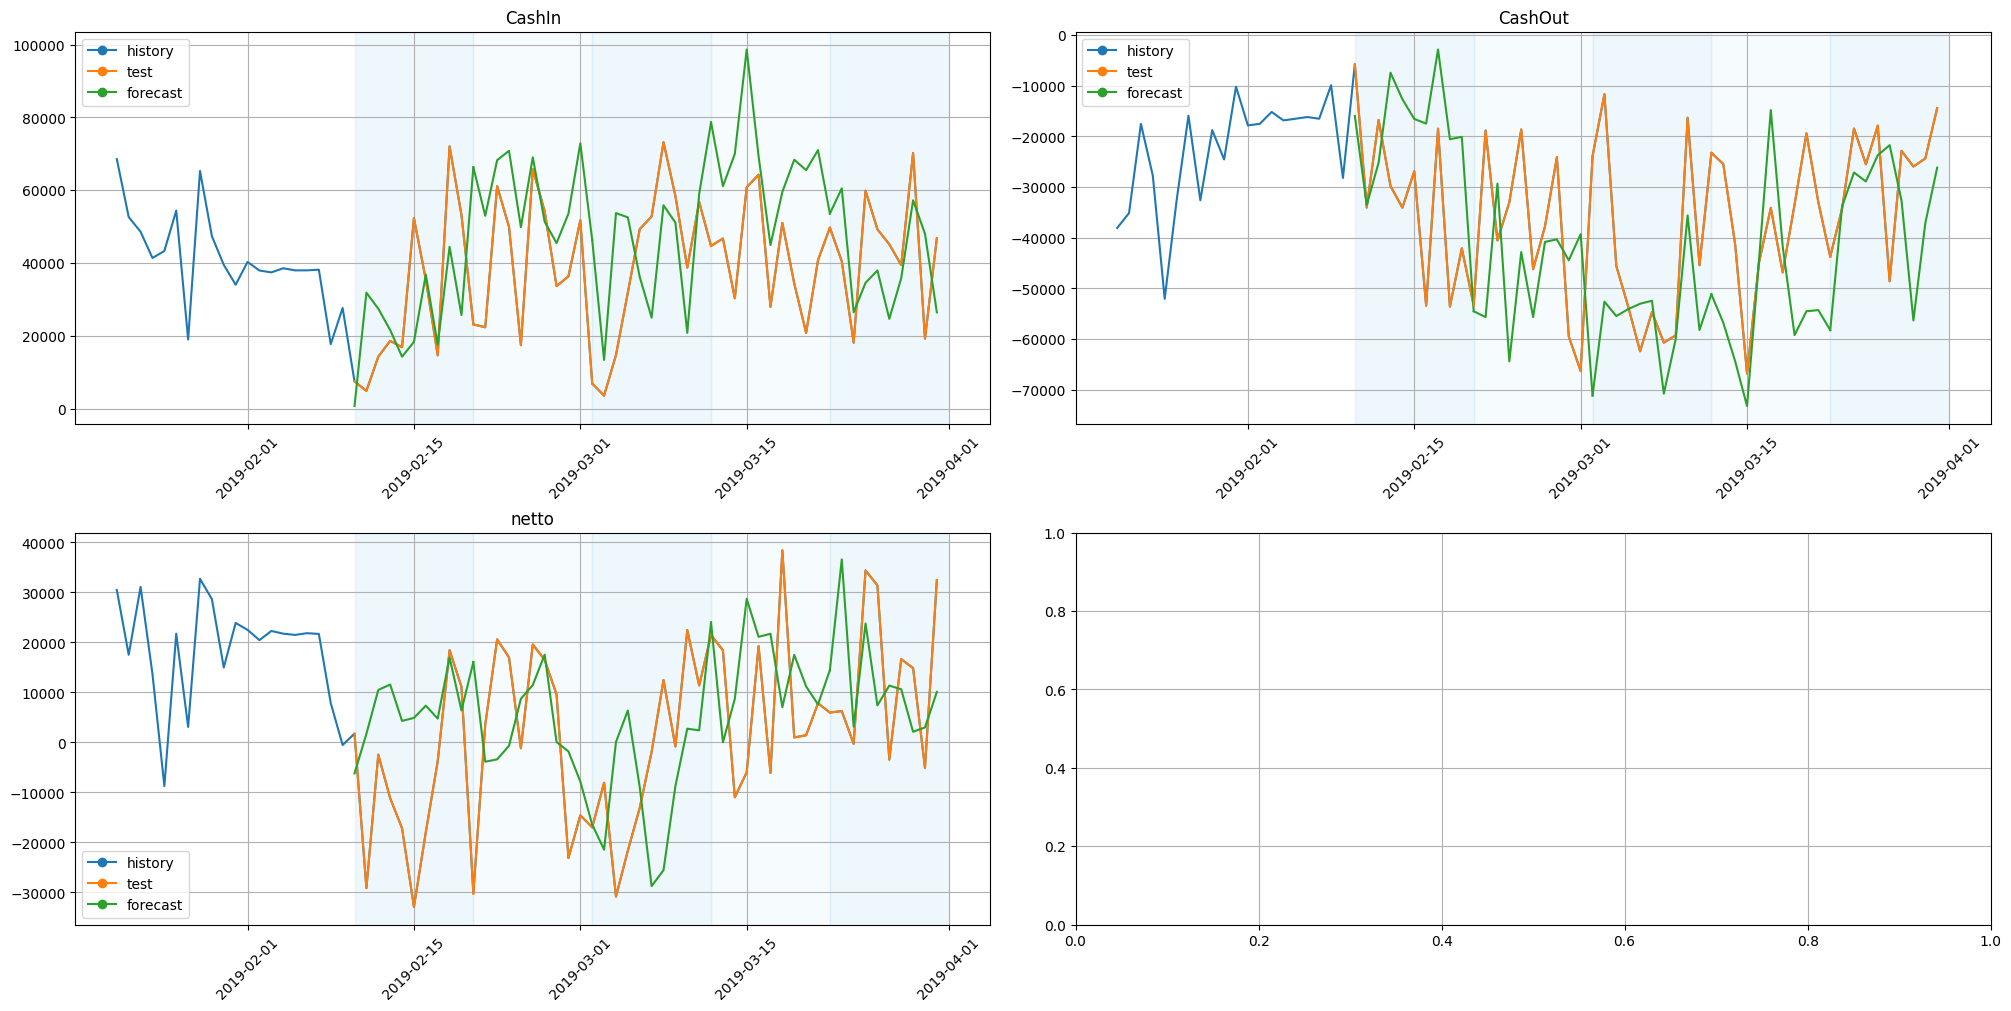

In [ ]:
plot_backtest(forecast_direct, transformed_ts, history_len=20)

Несмотря на то, что показатели метрики у `DirectEnsemble` выше, всё же прямая стратегия выигрывает в предсказании общего тренда и колебаний.

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
voting_ensemble = VotingEnsemble(pipelines=[pipeline, pipeline_catboost, pipeline_arima], weights=[2, 9, 7])

In [ ]:
metrics_voting, forecast_voting, _ = voting_ensemble.backtest(ts=transformed_ts, metrics=[SMAPE()], aggregate_metrics=True)

In [ ]:
metrics_voting

segment       SMAPE
0   CashIn   33.431266
1  CashOut   25.858990
2    netto  123.126355

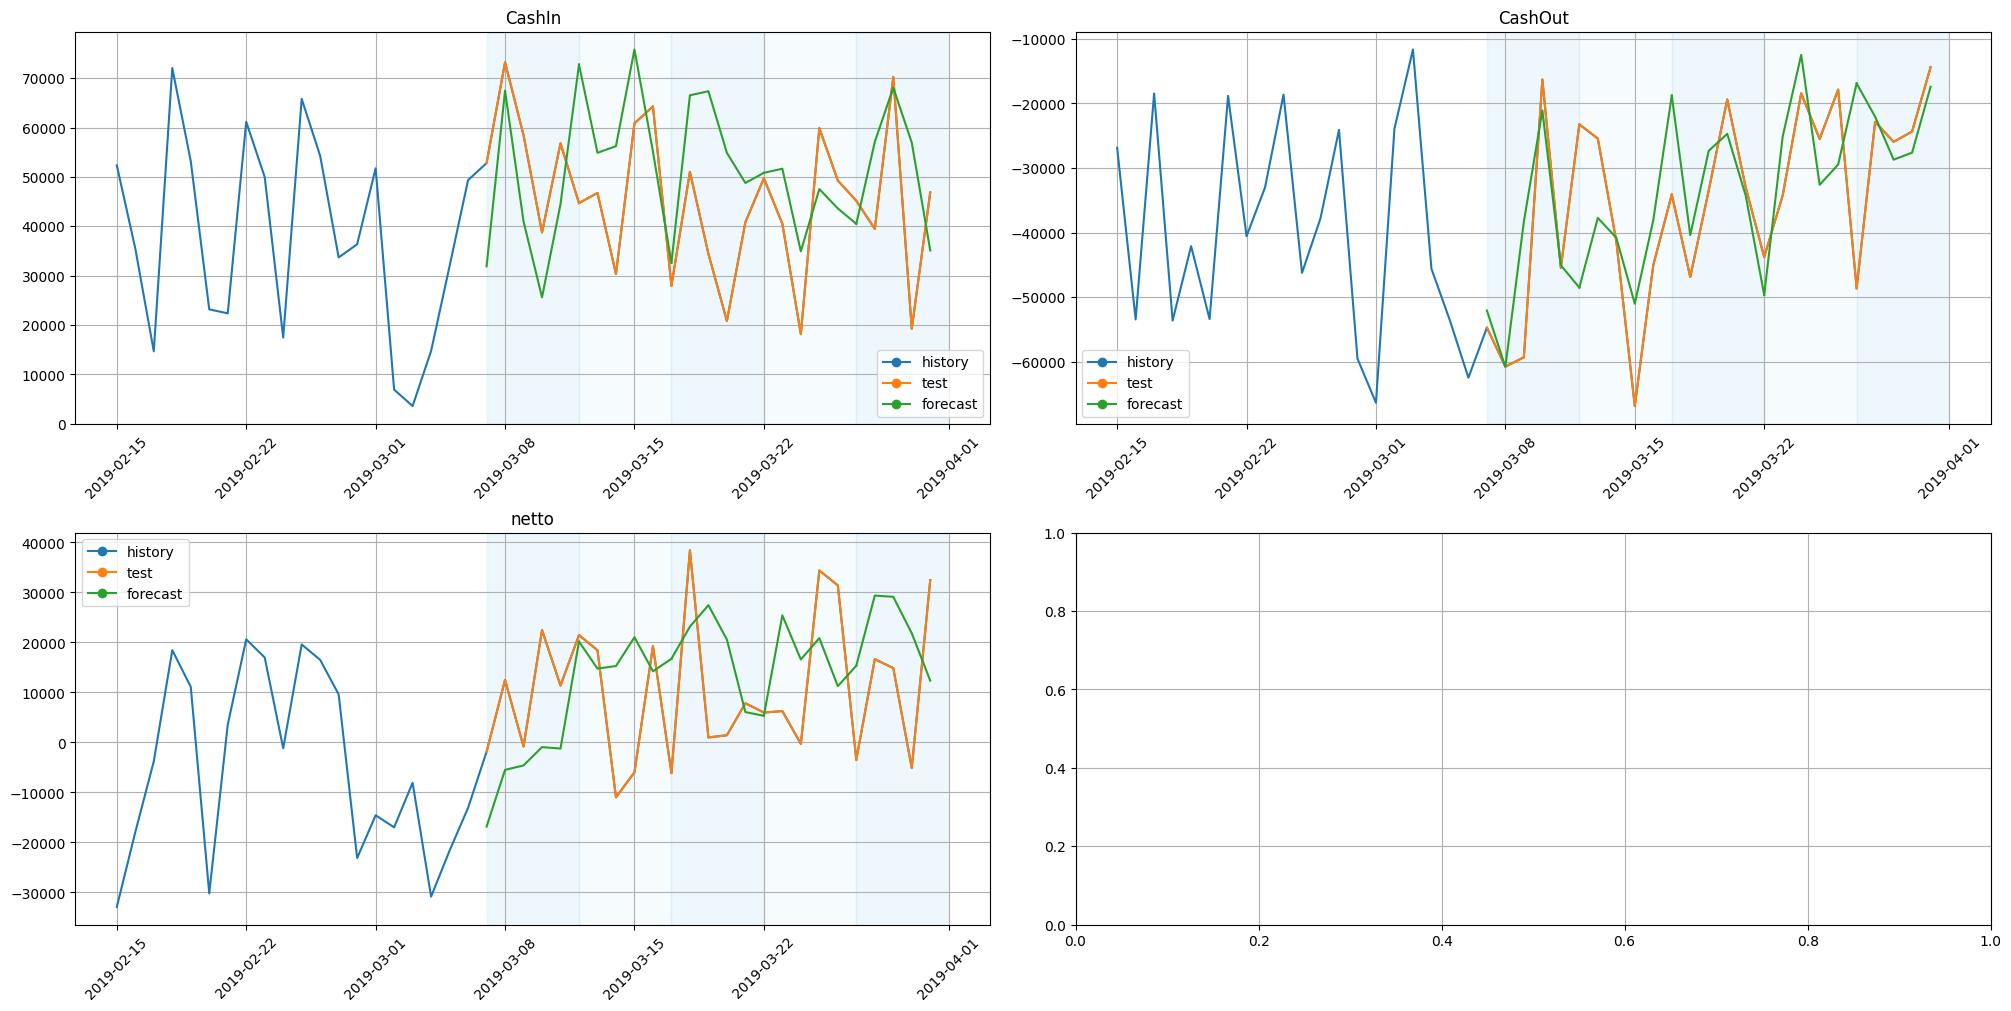

In [ ]:
plot_backtest(forecast_voting, transformed_ts, history_len=20)

In [ ]:
stacking_ensemble = StackingEnsemble([pipeline_catboost, pipeline_arima], n_folds=5)

In [ ]:
metrics_stacking, forecast_stacking, _ = stacking_ensemble.backtest(ts=transformed_ts, metrics=[SMAPE()], aggregate_metrics=True)

In [ ]:
metrics_stacking

segment       SMAPE
0   CashIn   34.675281
1  CashOut   32.527883
2    netto  136.315212

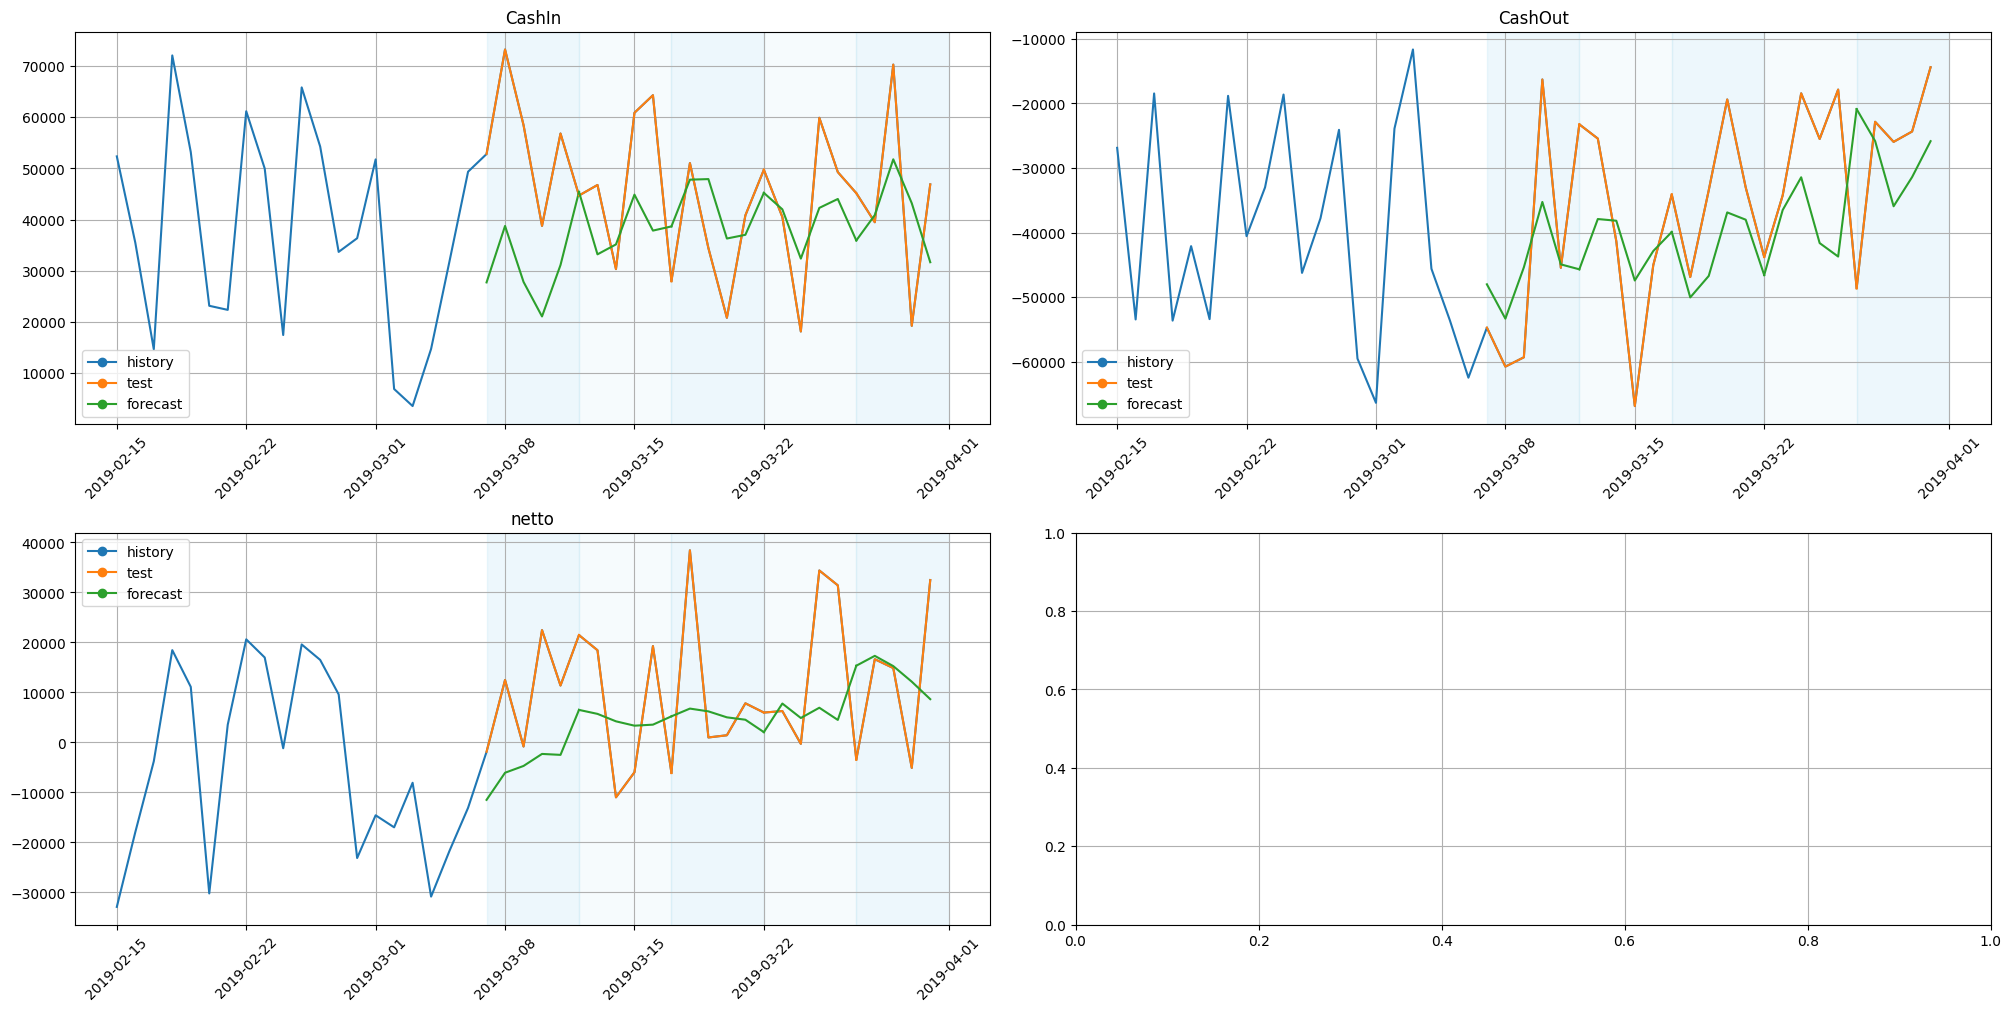

In [ ]:
plot_backtest(forecast_stacking, transformed_ts, history_len=20)

**Оценка: 9.9 / 10**

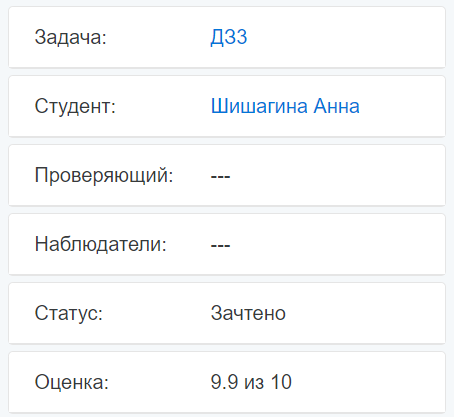